In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
file_path = "/data/work/shared/safe_data/sleep_skew/skew_project_start_oct_2022/"
phone_sample = pd.read_csv(file_path+"phone_data_s60.csv")
activity_sample = pd.read_csv(file_path+"steps_data_s60.csv")

'''Getting the sleeping info of the chosen user from another file'''
sleep_sample = pd.read_csv(file_path+"sleep_skew_data_w_demographics.csv")
sleep_sample['sleep_duration_round'] = np.round(sleep_sample['sleep_duration']/3600,2)
sleep_sample['day_label_shift'] = np.where(sleep_sample['start_time_num_round']>= 12, 
                                           sleep_sample['day_label'],
                                           sleep_sample['day_label']-1)

sleep_sample['start_time_num_round_25'] = ((sleep_sample['start_time_num_round']%1)*100/60)+sleep_sample['start_time_num_round'].astype(int)
sleep_sample['end_time_num_round_25'] = ((sleep_sample['end_time_num_round']%1)*100/60)+sleep_sample['end_time_num_round'].astype(int)

'''EXCEPTION HANDLING FOR 24.00 : SHOULD SHOW AS 00.00'''

sleep_sample['start_time_num_round_25'] = round(sleep_sample['start_time_num_round_25']*4)/4
sleep_sample['end_time_num_round_25'] = round(sleep_sample['end_time_num_round_25']*4)/4

sleep_sample['start_time_num_round_25'] = np.where(sleep_sample['start_time_num_round_25']==24,0,sleep_sample['start_time_num_round_25'])
sleep_sample['end_time_num_round_25'] = np.where(sleep_sample['end_time_num_round_25']==24,0,sleep_sample['end_time_num_round_25'])

''' EXCEPTION HANDLING FOR SLEEP ONSET BETWEEN 23.45 AND 23.59 : SHOW AS 23.75 '''
sleep_sample['start_time_num_round_25'] = np.where(((sleep_sample['start_time_num_round'] >= 23.45) &
                                                   (sleep_sample['start_time_num_round'] < 24.0)), 23.75,sleep_sample['start_time_num_round_25'])
sleep_sample['end_time_num_round_25'] = np.where(((sleep_sample['end_time_num_round'] >= 23.45) &
                                                      (sleep_sample['end_time_num_round'] < 24.0)), 23.75,sleep_sample['end_time_num_round_25']) 

''' 
Defining Naps and shift sleep
If someone sleeps between 11am and 3pm
    - Less than 3 hours : Nap
    = More than 3 hours : Shift worker sleep
'''
sleep_sample['nap'] = np.where(
    ((sleep_sample['sleep_duration_round']<3) & 
     (sleep_sample['start_time_num_round'] < 15) & 
     (sleep_sample['start_time_num_round'] > 11)),1,0)
sleep_sample['shift_sleep'] = np.where(
    ((sleep_sample['sleep_duration_round']>=3) & 
     (sleep_sample['start_time_num_round'] < 15) & 
     (sleep_sample['start_time_num_round'] > 11)),1,0)

'''Deleting shift sleeps'''
# sleep_sample = sleep_sample[sleep_sample['shift_sleep'] ==0]

sleep_sample.drop(columns={'gender','age_group','country','weekday'},inplace=True)
sleep_sample.sort_values(by=['user_id','day_label_shift','day_label','start_time_num_round'],inplace=True)
print("Number of rows: ",len(sleep_sample))
print("Unique users: ",len(sleep_sample['user_id'].unique()))
# print("Unique countries: ",len(sleep_sample['country'].unique()))

Number of rows:  31143768
Unique users:  112928


In [3]:
sleep_sample.head()

,user_id,day_label,day_label_shift,day_of_week,weekend,start_time_num_round,end_time_num_round,sleep_duration,sleep_duration_round,start_time_num_round_25,end_time_num_round_25,nap,shift_sleep
30176662,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16893,16893,Sun,0,23.40,7.50,28860,8.02,23.75,7.75,0,0
30176686,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16895,16894,Mon,0,0.05,7.10,24840,6.90,0.00,7.25,0,0
30176649,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16895,16895,Tue,0,21.00,2.35,19980,5.55,21.00,2.50,0,0
30176716,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16896,16896,Wed,0,22.05,6.40,30240,8.40,22.00,6.75,0,0
30176655,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16897,16897,Thu,0,22.20,7.00,28740,7.98,22.25,7.00,0,0


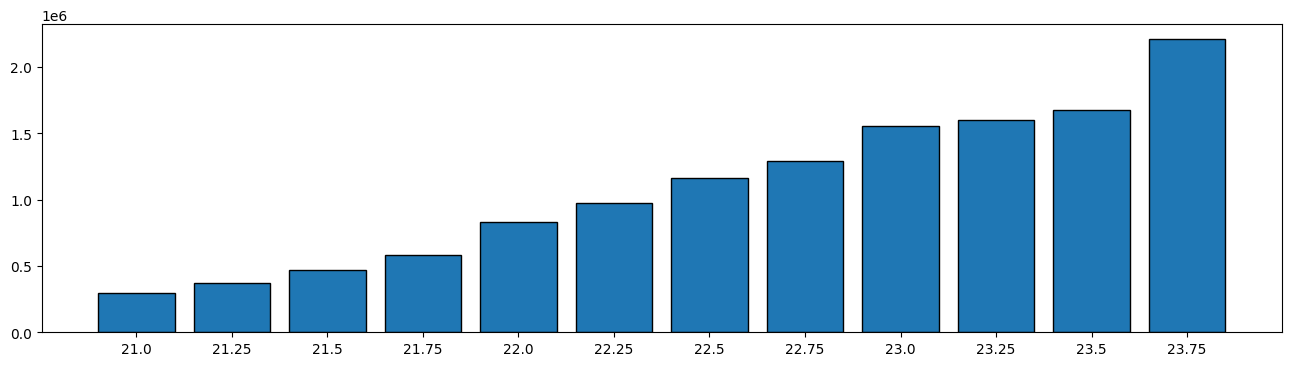

In [4]:
_r = pd.DataFrame(sleep_sample['start_time_num_round_25'].value_counts()).reset_index()
_r2 = _r[(_r['index']>=21)]
_r2 = _r2.sort_values(by='index').reset_index(drop=True)
_r2
plt.figure(figsize=(16,4))
plt.bar(_r2['index'].astype(str), _r2['start_time_num_round_25'],edgecolor='black')
# plt.xticks(np.arange(21,24.25,0.25))
plt.show()
# plt.figure(figsize=(16,4))
# counts, bins = np.histogram(_r2['start_time_num_round_25'])
# print(counts, bins)

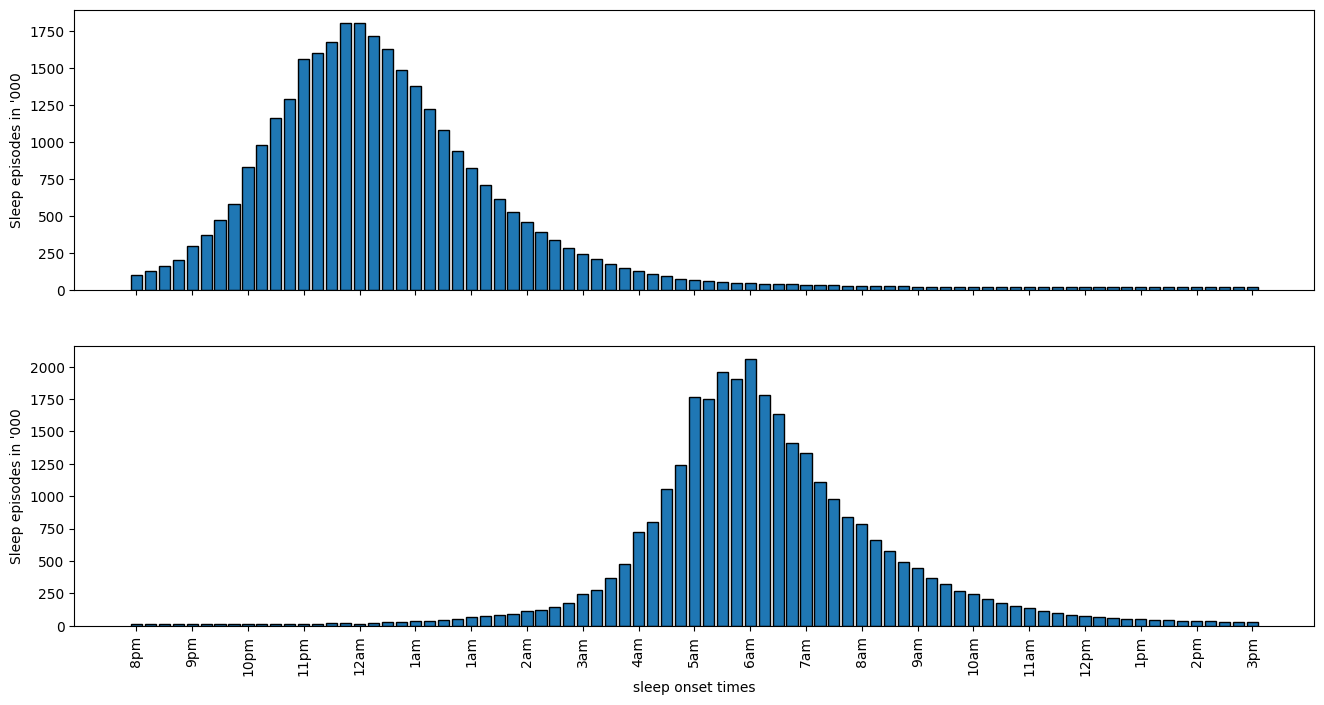

In [18]:
sleep_sample['sleep_onset_48hr'] = np.where(sleep_sample['start_time_num_round_25']>=19,
                                           sleep_sample['start_time_num_round_25'],
                                           sleep_sample['start_time_num_round_25']+24)

sleep_sample['sleep_offset_48hr'] = np.where(sleep_sample['end_time_num_round_25']>=19,
                                           sleep_sample['end_time_num_round_25'],
                                           sleep_sample['end_time_num_round_25']+24)

_r = pd.DataFrame(sleep_sample['sleep_onset_48hr'].value_counts()).reset_index()
_r.sort_values(by='index',inplace=False)
_r[_r['index'].between(23,24)]
_r3['sleep_onset_48hr'] = _r3['sleep_onset_48hr']/1000
_r3
fig, axs = plt.subplots(2,1,figsize=(16,8),sharex=True)

x_ticks = np.arange(0,len(_r3),4)
x_values = _r3['index'].astype(str)
axs[0].bar(x_values, _r3['sleep_onset_48hr'],edgecolor='black')
axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels([x_values[i] for i in x_ticks])
axs[0].set_xticklabels(['8pm','9pm','10pm','11pm','12am','1am','1am','2am','3am','4am','5am','6am','7am',
                       '8am','9am','10am','11am','12pm','1pm','2pm','3pm'])

axs[0].set_ylabel("Sleep episodes in '000")
_r = pd.DataFrame(sleep_sample['sleep_offset_48hr'].value_counts()).reset_index()
_r3 = _r[(_r['index'].between(20,40))]
_r3 = _r3.sort_values(by='index').reset_index(drop=True)
_r3['sleep_offset_48hr'] = _r3['sleep_offset_48hr']/1000
axs[1].bar(_r3['index'].astype(str), _r3['sleep_offset_48hr'],edgecolor='black')
axs[1].tick_params('x',rotation=90)
axs[1].set_xlabel("sleep onset times")
axs[1].set_ylabel("Sleep episodes in '000")
plt.savefig("/file/out/antar/sleeponsetvsleepnight.png",dpi=400)
plt.show()

In [342]:
_skew = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').skew()
_skew = _skew.reset_index()
_skew.rename(columns={'sleep_duration_round':'sleep_duration_hour_skew'},inplace=True)

_med = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').median()
_med = _med.reset_index()
_med.rename(columns = {'sleep_duration_round':'sleep_duration_median'},inplace=True)
_skew = _skew.merge(_med,how='left', left_on='user_id',right_on='user_id')
_skew['sleep_dur_median_bucket']= np.round(_skew['sleep_duration_median']*2)/2
_skew.sort_values(by='sleep_duration_hour_skew',ascending=False, inplace=True)
_skew.head(n=1)

,user_id,sleep_duration_hour_skew,sleep_duration_median,sleep_dur_median_bucket
91046,cdd97da3bba1bc2f786bdae0630c548da32d7d276f987f...,6.116804,2.36,2.5


In [319]:
sleep_sample = sleep_sample.merge(_skew[['user_id','sleep_duration_hour_skew','sleep_duration_median']],
                                                  how='left',left_on='user_id',right_on='user_id')
sleep_sample.head()

,user_id,day_label,day_label_shift,day_of_week,weekend,start_time_num_round,end_time_num_round,sleep_duration,sleep_duration_round,start_time_num_round_25,end_time_num_round_25,nap,shift_sleep,sleep_onset_48hr,sleep_duration_hour_skew,sleep_duration_median
0,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16893,16893,Sun,0,23.40,7.50,28860,8.02,23.75,7.75,0,0,23.75,0.164235,7.465
1,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16895,16894,Mon,0,0.05,7.10,24840,6.90,0.00,7.25,0,0,24.00,0.164235,7.465
2,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16895,16895,Tue,0,21.00,2.35,19980,5.55,21.00,2.50,0,0,21.00,0.164235,7.465
3,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16896,16896,Wed,0,22.05,6.40,30240,8.40,22.00,6.75,0,0,22.00,0.164235,7.465
4,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,16897,16897,Thu,0,22.20,7.00,28740,7.98,22.25,7.00,0,0,22.25,0.164235,7.465


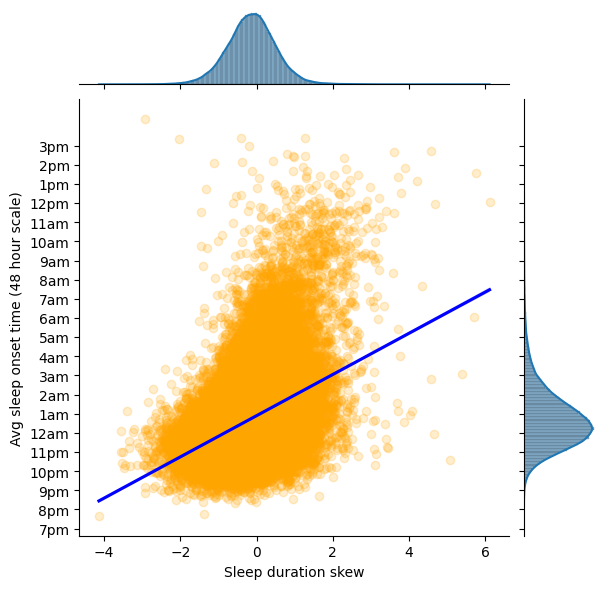

0.41751515713158194


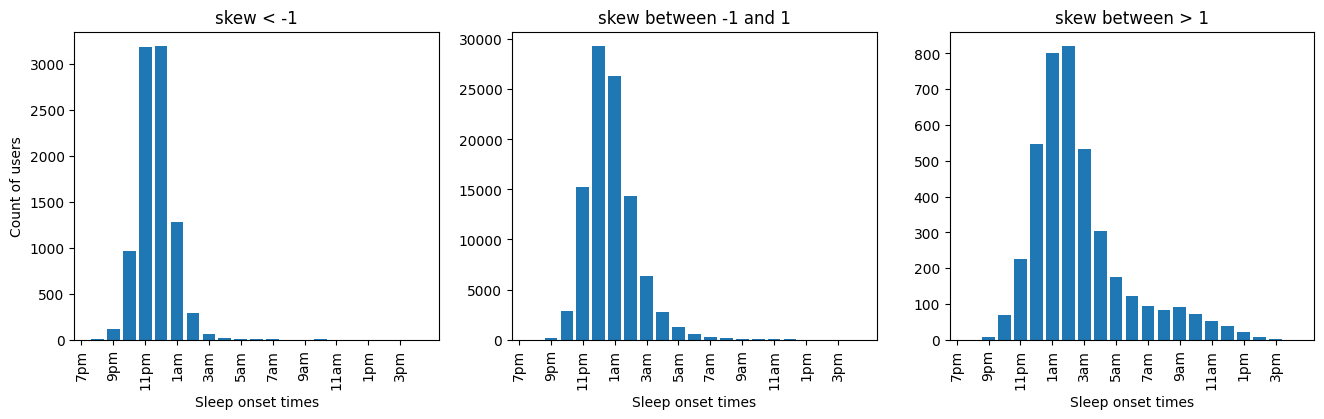

In [410]:
avgstart = sleep_sample[['user_id',
                         'sleep_duration_hour_skew',
                         'sleep_duration_median',
                         'sleep_onset_48hr']].groupby([
    'user_id','sleep_duration_hour_skew','sleep_duration_median']).mean().reset_index()
ax = sns.jointplot(data=avgstart,x='sleep_duration_hour_skew',y='sleep_onset_48hr',
                  kind = 'reg',scatter_kws={'color':'orange','alpha':0.2},line_kws = {'color':'blue'})
ax.ax_joint.set_xlabel("Sleep duration skew")
ax.ax_joint.set_ylabel("Avg sleep onset time (48 hour scale)")
ax.ax_joint.set_yticks(ticks=np.arange(19,40,1)) # prev 43
ax.ax_joint.set_yticklabels(['7pm','8pm','9pm','10pm','11pm','12am','1am','2am','3am','4am','5am','6am',
                             '7am','8am', '9am', '10am','11am','12pm','1pm','2pm','3pm'])

plt.savefig("/file/out/antar/sleeponset_jointplot1.png")
plt.show()
np.corrcoef(avgstart['sleep_duration_hour_skew'],avgstart['sleep_onset_48hr'])
x1 = (avgstart['sleep_duration_hour_skew']- np.mean(avgstart['sleep_duration_hour_skew']))/np.std(avgstart['sleep_duration_hour_skew'])
x2 = (avgstart['sleep_onset_48hr']- np.mean(avgstart['sleep_onset_48hr']))/np.std(avgstart['sleep_onset_48hr'])

print(np.cov(x1,x2)[0,1]/np.var(x1))
fig, axs = plt.subplots(1,3, figsize=(16,4),sharex= True)
axs = axs.flatten()
_sub = avgstart[avgstart['sleep_duration_hour_skew']<-1]
_sub['sleep_onset_rounded'] = _sub['sleep_onset_48hr'].apply(rounding)
_subdf = pd.DataFrame(_sub['sleep_onset_rounded'].value_counts().reset_index())
axs[0].bar(_subdf['index'],_subdf['sleep_onset_rounded'])
axs[0].set_title("skew < -1")
axs[0].set_xticks(np.arange(19,40,2)) # prev 43
axs[0].set_xticklabels(['7pm','9pm','11pm','1am','3am','5am','7am','9am','11am','1pm','3pm'])
axs[0].tick_params('x',rotation=90)
axs[0].set_ylabel("Count of users")
axs[0].set_xlabel("Sleep onset times")
_sub = avgstart[avgstart['sleep_duration_hour_skew'].between(-1,1)]
_sub['sleep_onset_rounded'] = _sub['sleep_onset_48hr'].apply(rounding)
_subdf = pd.DataFrame(_sub['sleep_onset_rounded'].value_counts().reset_index())
axs[1].bar(_subdf['index'],_subdf['sleep_onset_rounded'])
axs[1].set_title("skew between -1 and 1")
axs[1].tick_params('x',rotation=90)
axs[1].set_xlabel("Sleep onset times")
_sub = avgstart[avgstart['sleep_duration_hour_skew']>1]
_sub['sleep_onset_rounded'] = _sub['sleep_onset_48hr'].apply(rounding)
_subdf = pd.DataFrame(_sub['sleep_onset_rounded'].value_counts().reset_index())
axs[2].bar(_subdf['index'],_subdf['sleep_onset_rounded'])
axs[2].set_title("skew between > 1")
axs[2].tick_params('x',rotation=90)
axs[2].set_xlabel("Sleep onset times")
plt.savefig("/file/out/antar/jointplot_onset2.png",dpi=400)
plt.show()



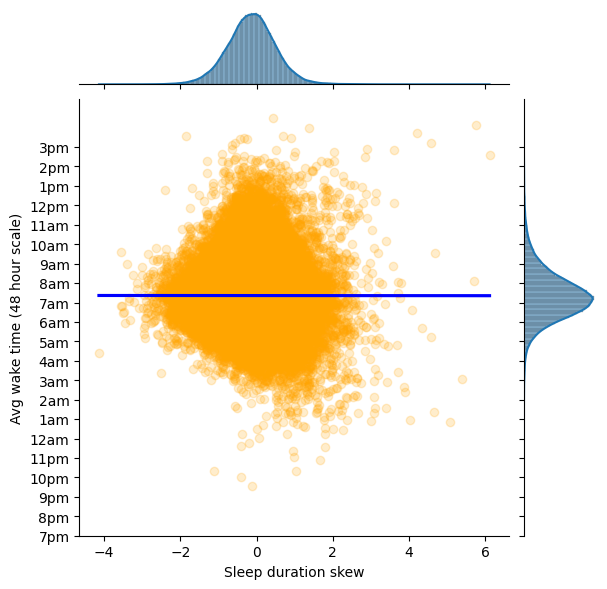

-0.0005296725712100233


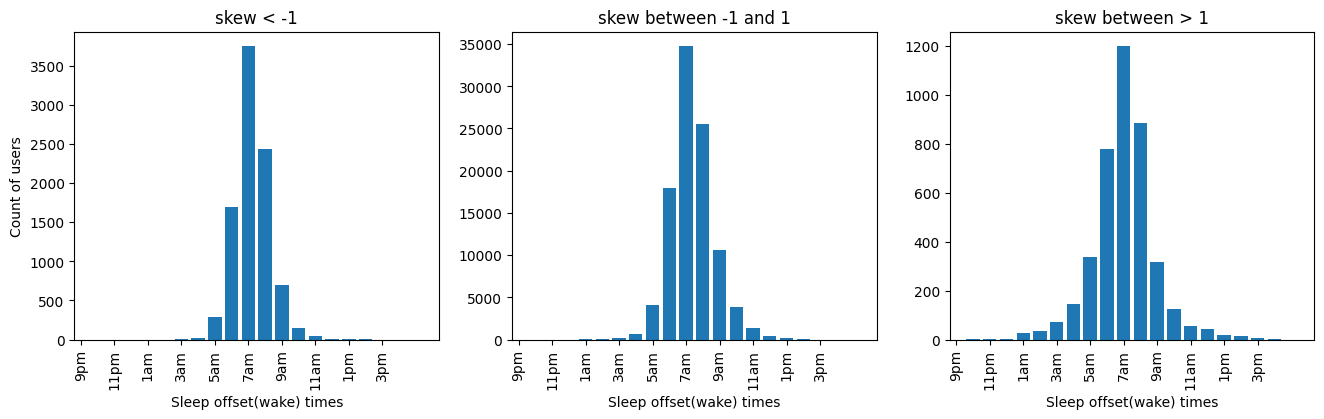

In [411]:
avgstart = sleep_sample[['user_id',
                         'sleep_duration_hour_skew',
                         'sleep_duration_median',
                         'sleep_offset_48hr']].groupby([
    'user_id','sleep_duration_hour_skew','sleep_duration_median']).mean().reset_index()
ax = sns.jointplot(data=avgstart,x='sleep_duration_hour_skew',y='sleep_offset_48hr',
                  kind = 'reg',scatter_kws={'color':'orange','alpha':0.2},line_kws = {'color':'blue'})
ax.ax_joint.set_xlabel("Sleep duration skew")
ax.ax_joint.set_ylabel("Avg wake time (48 hour scale)")
ax.ax_joint.set_yticks(ticks=np.arange(19,40,1)) # prev 43
ax.ax_joint.set_yticklabels(['7pm','8pm','9pm','10pm','11pm','12am','1am','2am','3am','4am','5am','6am',
                             '7am','8am', '9am', '10am','11am','12pm','1pm','2pm','3pm'])
plt.savefig("/file/out/antar/jointoffset1.png",dpi=400)
plt.show()
np.corrcoef(avgstart['sleep_duration_hour_skew'],avgstart['sleep_offset_48hr'])
x1 = (avgstart['sleep_duration_hour_skew']- np.mean(avgstart['sleep_duration_hour_skew']))/np.std(avgstart['sleep_duration_hour_skew'])
x2 = (avgstart['sleep_offset_48hr']- np.mean(avgstart['sleep_offset_48hr']))/np.std(avgstart['sleep_offset_48hr'])

print(np.cov(x1,x2)[0,1]/np.var(x1))
fig, axs = plt.subplots(1,3, figsize=(16,4),sharex=True)
axs = axs.flatten()
_sub = avgstart[avgstart['sleep_duration_hour_skew']<-1]
_sub['sleep_offset_rounded'] = _sub['sleep_offset_48hr'].apply(rounding)
_subdf = pd.DataFrame(_sub['sleep_offset_rounded'].value_counts().reset_index())
axs[0].bar(_subdf['index'],_subdf['sleep_offset_rounded'])
axs[0].set_title("skew < -1")
axs[0].set_xticks(np.arange(19,40,2)) # prev 43
axs[0].set_xticklabels(['7pm','9pm','11pm','1am','3am','5am','7am','9am','11am','1pm','3pm'])
axs[0].tick_params('x',rotation=90)
axs[0].set_ylabel("Count of users")
axs[0].set_xlabel("Sleep offset(wake) times")
_sub = avgstart[avgstart['sleep_duration_hour_skew'].between(-1,1)]
_sub['sleep_offset_rounded'] = _sub['sleep_offset_48hr'].apply(rounding)
_subdf = pd.DataFrame(_sub['sleep_offset_rounded'].value_counts().reset_index())
axs[1].bar(_subdf['index'],_subdf['sleep_offset_rounded'])
axs[1].set_title("skew between -1 and 1")
axs[1].tick_params('x',rotation=90)
axs[1].set_xlabel("Sleep offset(wake) times")
_sub = avgstart[avgstart['sleep_duration_hour_skew']>1]
_sub['sleep_offset_rounded'] = _sub['sleep_offset_48hr'].apply(rounding)
_subdf = pd.DataFrame(_sub['sleep_offset_rounded'].value_counts().reset_index())
axs[2].bar(_subdf['index'],_subdf['sleep_offset_rounded'])
axs[2].set_title("skew between > 1")
axs[2].tick_params('x',rotation=90)
axs[2].set_xlabel("Sleep offset(wake) times")
plt.savefig("/file/out/antar/jointoffset2.png",dpi=400)
plt.show()



In [133]:
phone_sample.head()

,user_id,duration,day_label,start_time_num_round
0,02889e92f6b969d31fa3e6ee5e24dc5e7653a39927935a...,281,17726,23.45
1,02889e92f6b969d31fa3e6ee5e24dc5e7653a39927935a...,56,17538,19.45
2,02889e92f6b969d31fa3e6ee5e24dc5e7653a39927935a...,224,17585,11.00
3,02889e92f6b969d31fa3e6ee5e24dc5e7653a39927935a...,196,17638,14.15
4,02889e92f6b969d31fa3e6ee5e24dc5e7653a39927935a...,121,17795,23.00


In [134]:
activity_sample.head()

,user_id,day_label,start_time_num_round,steps
0,06ae8bb39c0d59a7050f84e4ab2b789953d080b3fe4783...,17129,10.15,63.0
1,06ae8bb39c0d59a7050f84e4ab2b789953d080b3fe4783...,17390,20.30,1219.0
2,06ae8bb39c0d59a7050f84e4ab2b789953d080b3fe4783...,17429,14.30,686.0
3,06ae8bb39c0d59a7050f84e4ab2b789953d080b3fe4783...,17458,16.00,106.0
4,06ae8bb39c0d59a7050f84e4ab2b789953d080b3fe4783...,17483,10.00,880.0


## Creating a mapping for the users so that it can be used across the board

In [135]:
'''Identifying the unique users in phone and activity data and excluding customers from analysis who dont have
this data'''
unique_phone_users = phone_sample['user_id'].unique()
unique_activity_users = activity_sample['user_id'].unique()
sleep_sample = sleep_sample[(sleep_sample['user_id'].isin(unique_phone_users)) & 
                            (sleep_sample['user_id'].isin(unique_activity_users))]

print("Count of users in sleep data: ",len(sleep_sample['user_id'].unique()))

'''need to make a mapping between alpha numeric user ids and integer user_ids'''
user_id_mapping = pd.DataFrame(sleep_sample['user_id'].unique()).reset_index()
user_id_mapping.columns=['new_user_id','user_id']
user_id_mapping['new_user_id'] = user_id_mapping['new_user_id']+1
print(np.min(user_id_mapping['new_user_id']),np.max(user_id_mapping['new_user_id']))

def append_userid(df):
    df= df.merge(user_id_mapping,how='left',left_on = 'user_id',right_on='user_id')
    df.drop(columns={'user_id'},inplace=True)
    df.rename(columns={'new_user_id':'user_id'},inplace=True)
    return df
    
sleep_sample = append_userid(sleep_sample)
phone_sample = append_userid(phone_sample)
activity_sample = append_userid(activity_sample)

print("sleep data: ",sleep_sample.columns)
print("phone usage: ",phone_sample.columns)
print("activity: ",activity_sample.columns)


Count of users in sleep data:  3384
1 3384
sleep data:  Index(['day_label', 'day_label_shift', 'day_of_week', 'weekend',
       'start_time_num_round', 'end_time_num_round', 'sleep_duration',
       'sleep_duration_round', 'start_time_num_round_25',
       'end_time_num_round_25', 'nap', 'shift_sleep', 'user_id'],
      dtype='object')
phone usage:  Index(['duration', 'day_label', 'start_time_num_round', 'user_id'], dtype='object')
activity:  Index(['day_label', 'start_time_num_round', 'steps', 'user_id'], dtype='object')


In [136]:
sleep_sample.head(n=2)

,day_label,day_label_shift,day_of_week,weekend,start_time_num_round,end_time_num_round,sleep_duration,sleep_duration_round,start_time_num_round_25,end_time_num_round_25,nap,shift_sleep,user_id
0,16617,16617,Wed,0,12.45,19.00,22440,6.23,12.75,19.0,0,1,1
1,16618,16617,Thu,0,11.50,18.55,25620,7.12,11.75,19.0,0,1,1


In [137]:
phone_sample.head(n=2)

,duration,day_label,start_time_num_round,user_id
0,281,17726,23.45,28
1,56,17538,19.45,28


In [138]:
activity_sample.head(n=2)

,day_label,start_time_num_round,steps,user_id
0,17129,10.15,63.0,77.0
1,17390,20.30,1219.0,77.0


## Calculating sleep duration median and skew

In [315]:
_skew = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').skew()
_skew = _skew.reset_index()
_skew.rename(columns={'sleep_duration_round':'sleep_duration_hour_skew'},inplace=True)

_med = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').median()
_med = _med.reset_index()
_med.rename(columns = {'sleep_duration_round':'sleep_duration_median'},inplace=True)
_skew = _skew.merge(_med,how='left', left_on='user_id',right_on='user_id')
_skew['sleep_dur_median_bucket']= np.round(_skew['sleep_duration_median']*2)/2
_skew.sort_values(by='sleep_duration_hour_skew',ascending=False, inplace=True)
_skew

,user_id,sleep_duration_hour_skew,sleep_duration_median,sleep_dur_median_bucket
91046,cdd97da3bba1bc2f786bdae0630c548da32d7d276f987f...,6.116804,2.360,2.5
51590,751b6ff2ebb8d4b465774e461acc829d495652d9e403ff...,5.772849,2.400,2.5
66220,95be4aeeb0cea3948bb94641092be92c159c459bc3d634...,5.710220,3.000,3.0
7333,10efc6828f07e83102d01b86e507bcc4b36d81c782afb5...,5.384477,2.370,2.5
31230,4696b1e4660c4a01233627f3af59c4cb8e59347ae36ca6...,5.082906,2.820,3.0
...,...,...,...,...
26252,3ba78ec51661119c35b24a8a8acdd05b9760b5df11a656...,-3.511816,7.500,7.5
56692,8078c2e5d72169c97c08b607d5d59c571f4d801f46fdf4...,-3.519943,8.480,8.5
78654,b213f829e63214a7d4b3811e9662d1ca01b0ae7de42de6...,-3.547488,6.875,7.0
91944,d00ba82fef5319c328c8a205dc025f3efaedb105427a6c...,-3.560369,10.460,10.5


In [140]:
sleep_sample['sleep_onset_nearest_hour'] = np.round(sleep_sample['start_time_num_round_25'])
sleep_sample['sleep_offset_nearest_hour'] = np.round(sleep_sample['end_time_num_round_25'])
sleep_sample_byuser_onset = sleep_sample[['user_id','sleep_onset_nearest_hour']].groupby(['user_id','sleep_onset_nearest_hour']).size().reset_index()
sleep_sample_byuser_onset.rename(columns={0:'count_sleeps'},inplace=True)
sleep_sample_user_onset_pivot = pd.pivot_table(sleep_sample_byuser_onset,index='user_id',
                                               columns='sleep_onset_nearest_hour',values='count_sleeps')
sleep_sample_user_onset_pivot= sleep_sample_user_onset_pivot.fillna(0)


In [141]:
sleep_sample_user_onset_pivot= sleep_sample_user_onset_pivot[[14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9,
                                                             10,11,12,13]]
sleep_sample_user_onset_pivot

sleep_onset_nearest_hour,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,...,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,155.0,38.0,41.0,8.0,15.0,3.0,9.0,12.0,18.0,19.0,...,7.0,0.0,1.0,0.0,2.0,2.0,6.0,21.0,62.0,94.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,11.0,...,37.0,12.0,5.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,...,133.0,33.0,19.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3380,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0,...,114.0,37.0,30.0,2.0,4.0,3.0,0.0,3.0,1.0,1.0
3381,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,33.0,13.0,12.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3382,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,7.0,19.0,...,57.0,6.0,5.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0


<Figure size 1600x1000 with 0 Axes>

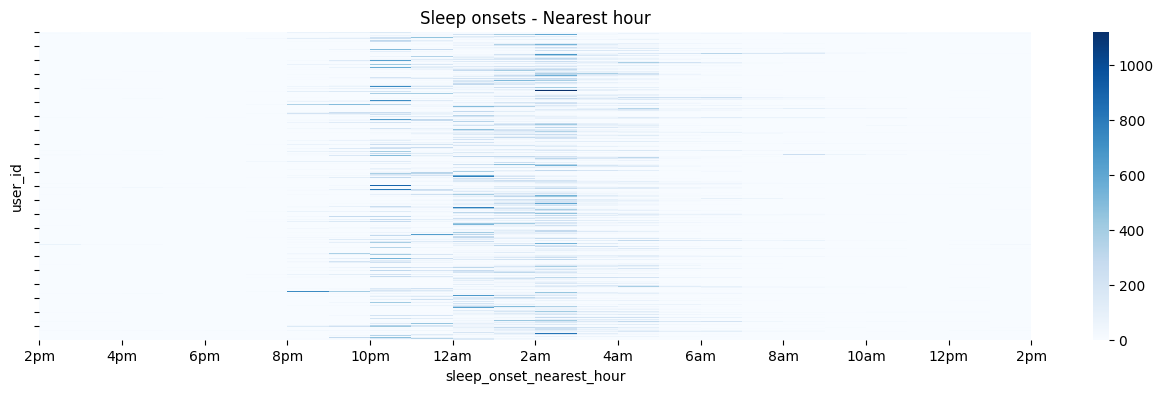

In [142]:
import seaborn as sns
plt.figure(figsize=(16,10))

fig,axs = plt.subplots(figsize=(16,4))

sns.heatmap(sleep_sample_user_onset_pivot,cmap='Blues')
axs.set_xticks(np.arange(0,26,2))
axs.set_xticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.set_yticklabels([])
plt.title("Sleep onsets - Nearest hour")
plt.show()

In [143]:
sleep_48hr = []
for i in range(len(sleep_sample)):
    if sleep_sample['start_time_num_round'].iloc[i] >= 19:
        sleep_48hr.append([sleep_sample['start_time_num_round'].iloc[i],sleep_sample['sleep_duration_round'].iloc[i]])
    else:
        sleep_48hr.append([sleep_sample['start_time_num_round'].iloc[i]+24,sleep_sample['sleep_duration_round'].iloc[i]])

sleep_48hr_df = pd.DataFrame(sleep_48hr, columns=['sleep_48hr','sleep_dur'])   
sleep_48hr_df

,sleep_48hr,sleep_dur
0,36.45,6.23
1,35.50,7.12
2,35.25,7.57
3,40.05,3.20
4,32.55,9.83
...,...,...
2067804,24.00,5.65
2067805,25.10,5.27
2067806,24.00,6.25
2067807,25.10,4.58


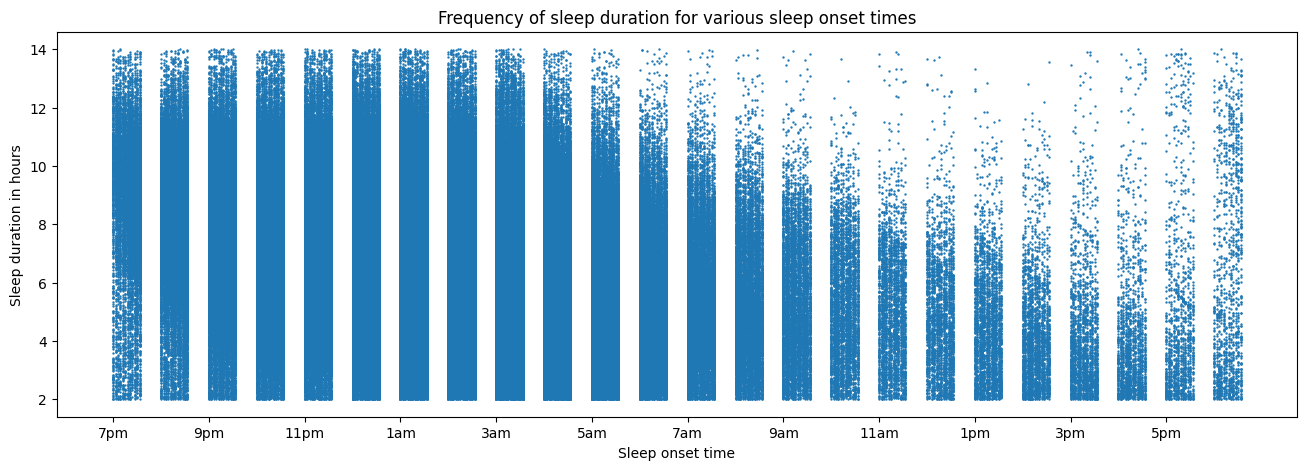

In [144]:

plt.figure(figsize=(16,5))
plt.scatter(sleep_48hr_df['sleep_48hr'],sleep_48hr_df['sleep_dur'],s= 0.5)

plt.xticks(ticks=np.arange(19,42,2), 
           labels=['7pm','9pm','11pm','1am','3am','5am','7am','9am','11am','1pm','3pm','5pm'])


plt.title("Frequency of sleep duration for various sleep onset times")
plt.xlabel("Sleep onset time")
plt.ylabel('Sleep duration in hours')
plt.show()

In [161]:
sleep_sample['sleep_onset_48hr'] = np.where(sleep_sample['start_time_num_round_25']>=19,
                                           sleep_sample['start_time_num_round_25'],
                                           sleep_sample['start_time_num_round_25']+24)

# sleep_sample = sleep_sample.merge(_skew[['user_id','sleep_duration_hour_skew','sleep_duration_median']],
#                                                   how='left',left_on='user_id',right_on='user_id')

sleep_sample['skew_direction'] = np.where(sleep_sample['sleep_duration_hour_skew'].between(-1,1),1,0)
sleep_sample.head(n=2)

,day_label,day_label_shift,day_of_week,weekend,start_time_num_round,end_time_num_round,sleep_duration,sleep_duration_round,start_time_num_round_25,end_time_num_round_25,nap,shift_sleep,user_id,sleep_onset_nearest_hour,sleep_offset_nearest_hour,sleep_onset_48hr,sleep_onset_48hr_nearest,sleep_duration_hour_skew,sleep_duration_median,skew_direction
0,16617,16617,Wed,0,12.45,19.00,22440,6.23,12.75,19.0,0,1,1,13.0,19.0,36.75,37.0,0.25791,6.32,1
1,16618,16617,Thu,0,11.50,18.55,25620,7.12,11.75,19.0,0,1,1,12.0,19.0,35.75,36.0,0.25791,6.32,1


In [254]:
np.round(21.25,1)

21.2

In [245]:
def rounding(value):
    _r = Decimal(value).quantize(0,ROUND_HALF_UP)
    return _r
times = pd.DataFrame(sleep_sample['start_time_num_round_25'].value_counts()).reset_index()
times2 = times[(times['index']>=21)]
times2['time_r'] = times2['index'].apply(rounding)
times2.sort_values(by='index',inplace=True)
times3 = pd.DataFrame(times2.groupby('time_r').sum()).reset_index()
times3
# plt.figure(figsize=(16,5))
# plt.bar(times2['time_r'],times2['start_time_num_round_25'],edgecolor='black')
# # plt.xticks(np.arange(0,25,0.25),rotation=90)
# plt.show()

/tmp/ipykernel_112769/4289261384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  times2['time_r'] = times2['index'].apply(rounding)
/tmp/ipykernel_112769/4289261384.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  times2.sort_values(by='index',inplace=True)


,time_r,index,start_time_num_round_25
0,21,42.25,52694
1,22,87.50,190846
2,23,91.50,215332
3,24,47.25,98087


In [261]:
AvgSleepStart_byuser['sleep_onset_48hr_25'] = round(AvgSleepStart_byuser['sleep_onset_48hr']*4)/4
_b = pd.DataFrame(AvgSleepStart_byuser['sleep_onset_48hr_25'].value_counts()).reset_index()
_b[_b['index']>=21].sort_values(by='index')
# sleep_sample['end_time_num_round_25'] = round(sleep_sample['end_time_num_round_25']*4)/4

,index,sleep_onset_48hr_25
27,21.00,22
23,21.25,46
20,21.50,71
19,21.75,73
7,22.00,143
8,22.25,136
9,22.50,135
15,22.75,96
17,23.00,77
24,23.25,34


In [267]:
condlist = [sleep_sample['sleep_duration_hour_skew'].between(-1,1),
            sleep_sample['sleep_duration_hour_skew'] > 1,
            sleep_sample['sleep_duration_hour_skew'] < -1]
choicelist = [1,2,3]
            
sleep_sample['skew_type']  = np.select(condlist,choicelist)
sleep_sample['skew_type'].value_counts()

1    1786519
3     198207
2      83083
Name: skew_type, dtype: int64

In [234]:
import math
AvgSleepStart_byuser = sleep_sample[['user_id','sleep_duration_hour_skew','sleep_duration_median',
                                     'sleep_onset_48hr']].groupby(['user_id',
                                                                   'sleep_duration_hour_skew','sleep_duration_median']).median().reset_index()
def rounding(value):
    _r = Decimal(value).quantize(0,ROUND_HALF_UP)
    return _r

AvgSleepStart_byuser['sleep_onset_48hr_nearest'] = AvgSleepStart_byuser['sleep_onset_48hr'].apply(rounding)
AvgSleepStart_byuser['sleep_onset_48hr_nearest'].value_counts()

26    884
25    645
27    453
22    425
23    339
24    267
28    159
21     89
29     64
30     23
31     10
32      8
20      8
33      5
35      2
36      1
37      1
34      1
Name: sleep_onset_48hr_nearest, dtype: int64

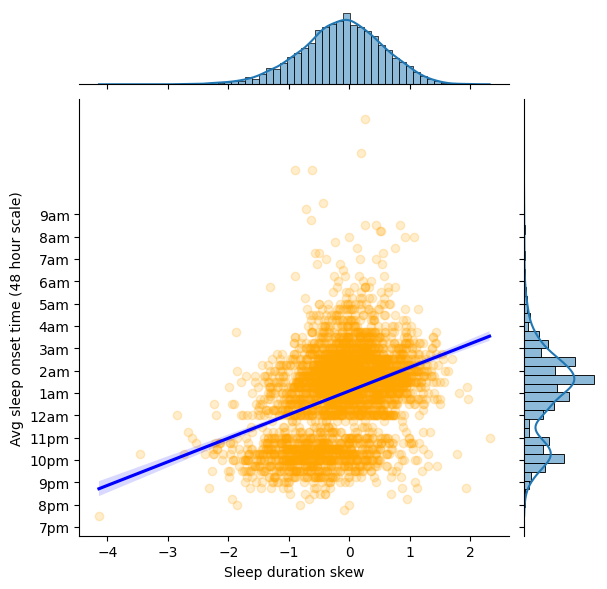

users count:  353
number of sleeps:  353
users count:  2896
number of sleeps:  2896
users count:  135
number of sleeps:  135


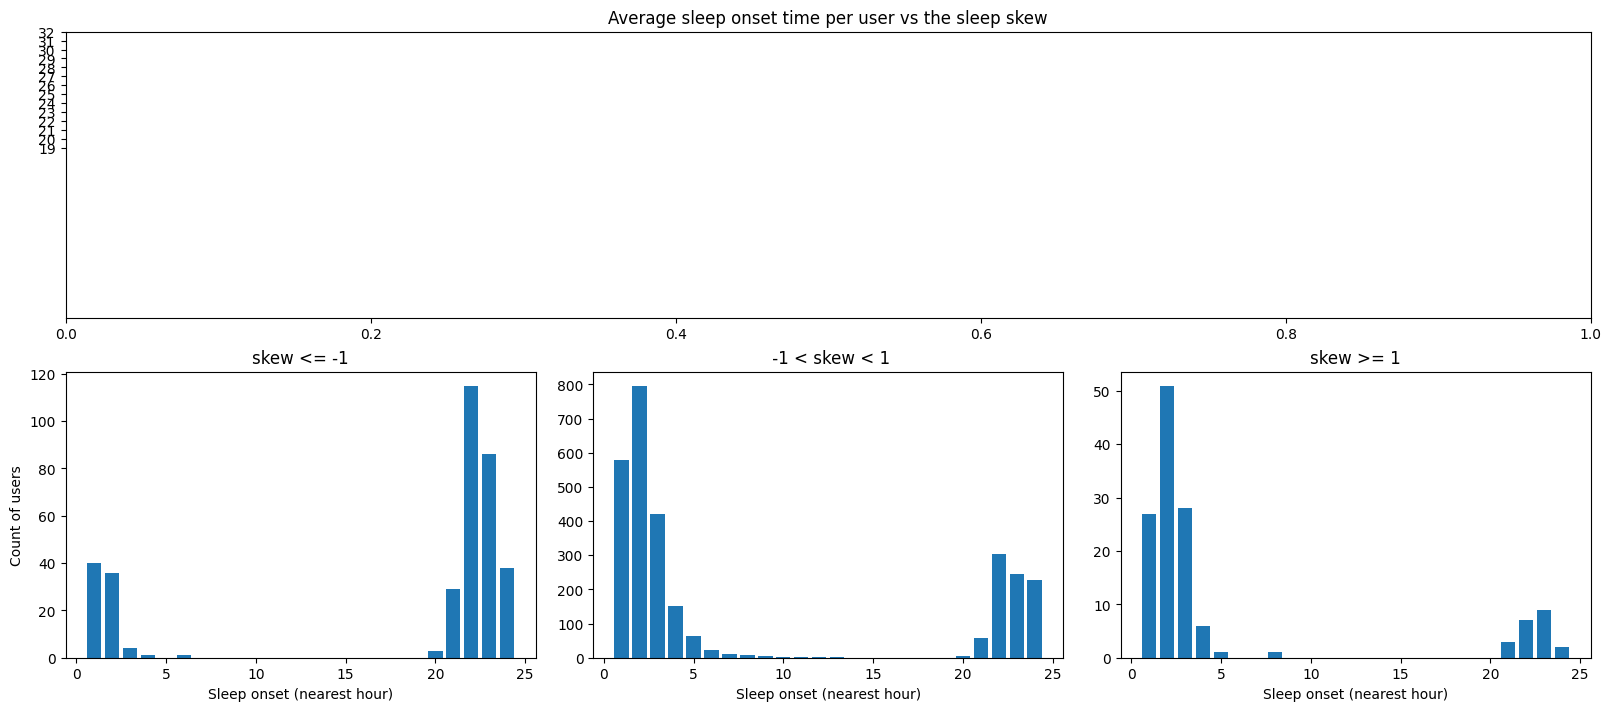

In [232]:
ax = sns.jointplot(data=AvgSleepStart_byuser,x='sleep_duration_hour_skew',y='sleep_onset_48hr',
                  kind = 'reg',scatter_kws={'color':'orange','alpha':0.2},line_kws = {'color':'blue'})
ax.ax_joint.set_xlabel("Sleep duration skew")
ax.ax_joint.set_ylabel("Avg sleep onset time (48 hour scale)")
ax.ax_joint.set_yticks(ticks=np.arange(19,34,1)) # prev 43
# ax.ax_joint.set_yticklabels(['7pm','9pm','11pm','1am','3am','5am','7am','9am','11am','1pm','3pm','5pm'])
ax.ax_joint.set_yticklabels(['7pm','8pm','9pm','10pm','11pm','12am','1am','2am','3am','4am','5am','6am','7am','8am', '9am'])

# plt.savefig("/file/out/antar/sleeponset_jointplot.png",dpi=400)
plt.show()

fig3 = plt.figure(constrained_layout=True,figsize=(16,7))
gs = fig3.add_gridspec(2,3)
f3_1 = fig3.add_subplot(gs[0,:])
# f3_1.scatter(AvgSleepStart_byuser['sleep_duration_hour_skew'],AvgSleepStart_byuser['sleep_onset_48hr'],
#              s=2)


f3_1.set_yticks(ticks=np.arange(19,33,1)) # prev 43
# f3_1.set_yticklabels(['7pm','9pm','11pm','1am','3am','5am','7am','9am','11am','1pm','3pm','5pm'])
# f3_1.set_yticklabels(['7pm','8pm','9pm','10pm','11pm','12pm','1am','2am','3am','4am','5am','6am','7am','8am'])
# f3_1.set_xticks(ticks=np.arange(-4,5,1))
f3_1.set_title("Average sleep onset time per user vs the sleep skew")
# f3_1.set_ylabel("Avg sleep onset time")
# f3_1.set_xlabel("Sleep skew")

f3_2 = fig3.add_subplot(gs[-1,0])

AvgSleepStart_byuser['sleep_onset_48hr_nearest']= np.where(AvgSleepStart_byuser['sleep_onset_48hr_nearest'] >24,
                                                            AvgSleepStart_byuser['sleep_onset_48hr_nearest']-24,
                                                            AvgSleepStart_byuser['sleep_onset_48hr_nearest'])


l1 =list(_skew[_skew['sleep_duration_hour_skew']<= -1]['user_id'])
print("users count: ",len(l1))
_l1 = AvgSleepStart_byuser[AvgSleepStart_byuser['user_id'].isin(l1)][['sleep_onset_48hr_nearest']]
print("number of sleeps: ",len(_l1))
# _l1['nearest_hour'] = np.round(_l1['sleep_onset_48hr'])
_l1 = pd.DataFrame(_l1['sleep_onset_48hr_nearest'].value_counts()).reset_index()
_l1.columns = ['sleep_onset_nearest_hour','freq']
_l1
f3_2.bar(_l1['sleep_onset_nearest_hour'],_l1['freq'])
f3_2.set_title("skew <= -1")
f3_2.set_ylabel("Count of users")
f3_2.set_xlabel("Sleep onset (nearest hour)")
f3_3 = fig3.add_subplot(gs[-1,1])

l1 =list(_skew[(_skew['sleep_duration_hour_skew']< 1) & (_skew['sleep_duration_hour_skew']> -1)]['user_id'])
print("users count: ",len(l1))
_l1 = AvgSleepStart_byuser[AvgSleepStart_byuser['user_id'].isin(l1)][['sleep_onset_48hr_nearest']]
print("number of sleeps: ",len(_l1))
# _l1['nearest_hour'] = np.round(_l1['sleep_onset_48hr'])
_l1 = pd.DataFrame(_l1['sleep_onset_48hr_nearest'].value_counts()).reset_index()
_l1.columns = ['sleep_onset_nearest_hour','freq']
_l1
f3_3.bar(_l1['sleep_onset_nearest_hour'],_l1['freq'])

f3_3.set_xlabel("Sleep onset (nearest hour)")
f3_3.set_title(" -1 < skew < 1")

f3_4 = fig3.add_subplot(gs[-1,-1])

l1 =list(_skew[_skew['sleep_duration_hour_skew']>= 1]['user_id'])
print("users count: ",len(l1))
_l1 = AvgSleepStart_byuser[AvgSleepStart_byuser['user_id'].isin(l1)][['sleep_onset_48hr_nearest']]
print("number of sleeps: ",len(_l1))
# _l1['nearest_hour'] = np.round(_l1['sleep_onset_48hr'])
_l1 = pd.DataFrame(_l1['sleep_onset_48hr_nearest'].value_counts()).reset_index()
_l1.columns = ['sleep_onset_nearest_hour','freq']
_l1
f3_4.bar(_l1['sleep_onset_nearest_hour'],_l1['freq'])
f3_4.set_xlabel("Sleep onset (nearest hour)")
f3_4.set_title("skew >= 1")

# plt.savefig("/file/out/antar/SleepOnsetForDifferentSkews.png",dpi=400)

plt.show()

## Analysing sleep duration against sleep end time for different skew windows

In [99]:
AvgSleepEnd_byuser = sleep_sample[['user_id','end_time_num_round']].groupby(['user_id']).mean().reset_index()

AvgSleepEnd_byuser = AvgSleepEnd_byuser.merge(_skew[['user_id','sleep_duration_hour_skew','sleep_duration_median']],
                                                  how='left',left_on='user_id',right_on='user_id')
AvgSleepEnd_byuser.sort_values(by='end_time_num_round',inplace=True)
AvgSleepEnd_byuser['avg_sleep_End_48hr']=np.where(AvgSleepEnd_byuser['end_time_num_round']>=19,
                                                     AvgSleepEnd_byuser['end_time_num_round'],
                                                     AvgSleepEnd_byuser['end_time_num_round']+24)
print(AvgSleepEnd_byuser['avg_sleep_End_48hr'].min())

AvgSleepEnd_byuser['sleep_offset_nearest_48hour']= np.where(AvgSleepEnd_byuser['avg_sleep_End_48hr'] >24,
                                                            np.round(AvgSleepEnd_byuser['avg_sleep_End_48hr']-24,0),
                                                            np.round(AvgSleepEnd_byuser['avg_sleep_End_48hr'],0))

AvgSleepEnd_byuser


26.024474789915967


,user_id,end_time_num_round,sleep_duration_hour_skew,sleep_duration_median,avg_sleep_End_48hr,sleep_offset_nearest_48hour
670,671,2.024475,0.949948,5.600,26.024475,2.0
71,72,2.555752,-0.405395,5.980,26.555752,3.0
208,209,2.608219,1.092867,4.820,26.608219,3.0
874,875,2.964050,0.879026,5.480,26.964050,3.0
2755,2756,2.965665,1.115389,5.680,26.965665,3.0
...,...,...,...,...,...,...
0,1,16.100000,0.257910,6.320,40.100000,16.0
2595,2596,16.209710,-0.430813,7.275,40.209710,16.0
803,804,16.418030,-0.904956,6.520,40.418030,16.0
2501,2502,16.605159,0.196415,6.500,40.605159,17.0


## Checking models behavior with three types of user sleep patterns over 30 days:
    * Regular sleep start at 2300 hrs and wake at 0500 for 30 days
    * Regular sleep start at 0800 and wake at 1500 for the first 15 days and 2300 - 0500 for the remaining
    * Regular sleep start at 0800 and wake at 1500 for 30 days

### User sleeping at 2300 and waking up at 0500 everyday

In [5]:
c1 = [2,3,4]
c2 = [6,7,8]
c1= c1+c2
c1

[2, 3, 4, 6, 7, 8]

len of df:  31


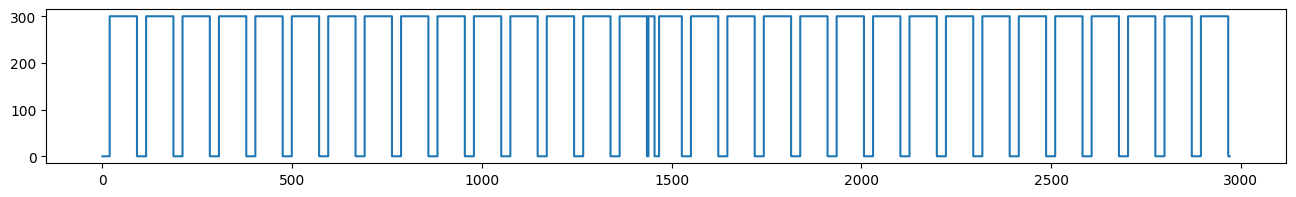

,start_time_num_round,end_time_num_round,sleep_duration_round
0,23.0,5.0,6.0
1,23.0,5.0,6.0
2,23.0,5.0,6.0
3,23.0,5.0,6.0
4,23.0,5.0,6.0
5,23.0,5.0,6.0
6,23.0,5.0,6.0
7,23.0,5.0,6.0
8,23.0,5.0,6.0
9,23.0,5.0,6.0


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
'''
User sleeping at 2300 and waking up at 0500 everyday
'''
num_days=30
interim = 10

hourly_light = [0,0,0,0,0,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,0]
exception_light = [300,300,300,300,0,0,0,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,0]
_df= []
for i in range(interim):
    _df.append([23.0,5.0,6.0])
_df.append([4.0,7.0,3.0])
for i in range(num_days-interim):
    _df.append([23.0,5.0,6.0])
_df = pd.DataFrame(_df,columns=['start_time_num_round','end_time_num_round','sleep_duration_round'])   
print("len of df: ", len(_df))

light_values = []
for hour in hourly_light:
    if hour == 0:
        j=0
        while j <4:
            light_values.append(0)
            j+=1
    else:
        j=0
        while j <4:
            light_values.append(300)
            j+=1
            
excep_light_values = []
for hour in exception_light:
    if hour == 0:
        j=0
        while j <4:
            excep_light_values.append(0)
            j+=1
    else:
        j=0
        while j <4:
            excep_light_values.append(300)
            j+=1
            
light_values_c = light_values*(int(num_days/2))
light_values_c += excep_light_values
light_values_c += light_values*(int(num_days/2))
plt.figure(figsize=(16,2))
plt.step(np.arange(0,len(light_values_c),1),light_values_c)
plt.show()
_df

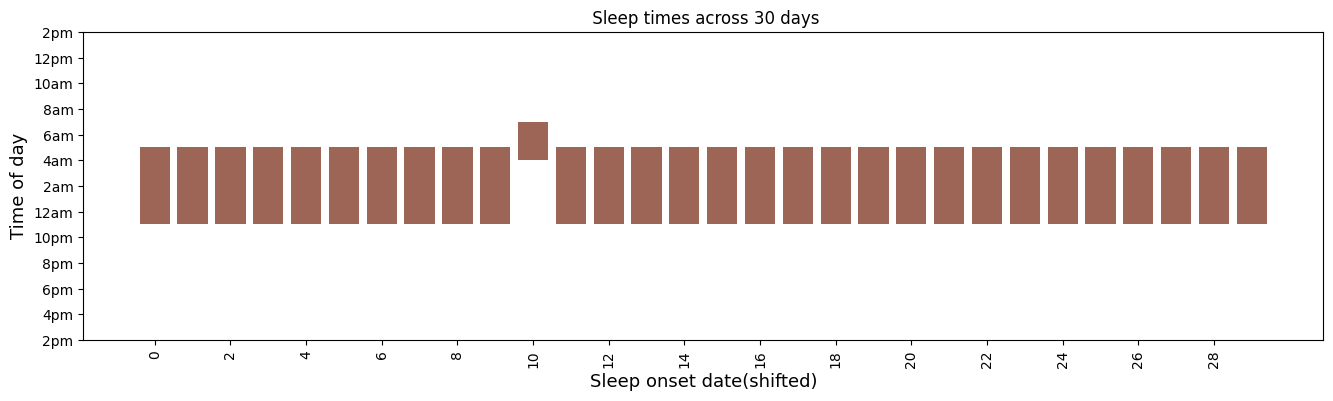

In [49]:
sleeping = np.array(_df['start_time_num_round'])
sleeping_48hour = []
for sleeping_time in sleeping:
    if sleeping_time < 12.00:
        sleeping_48hour.append(sleeping_time+24.00)
    else:
        sleeping_48hour.append(sleeping_time) 
    

                
SleepingDates = np.arange(0,num_days,1)
sleep_duration = _df['sleep_duration_round']

SleepingDates_48hr = pd.DataFrame(zip(SleepingDates, sleeping_48hour,sleep_duration),
                                  columns=['sleep_start_shift','start_time_num_round',
                                           'sleep_duration_round']) #converting to df


    
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color='#9D6556')

set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)",fontsize=13)
plt.ylabel("Time of day",fontsize=13)

plt.show()

In [18]:
SleepingDates_48hr.loc[0, 'start_time_num_round']

23.0

In [2]:

import numpy as np
from scipy.signal import find_peaks
def initial_conditions_loop(ts: np.ndarray, #Array of time points, also determines step size of RK4 solver
                                light_est: np.ndarray, #Array of light estimates, should be the same length as ts
                                num_loops: int = 30) -> np.ndarray: 
        """ 
            Estimate the starting values by looping the given light_estimate, commonly used for to estimate the initial conditions
            assumes the individual lives the same schedule repeatedly
        """
        y = np.array([-0.3,-1.13,0.0])
#         y = np.array([x1,x2,0.0])
        for _ in range(num_loops):
            sol = integrate_model(ts, light_est, y)
            y = sol[..., -1]
        return y,sol

def integrate_model(ts: np.array,  # Array of time points, also determines step size of RK4 solver
                    light_est: np.array,  # Array of light estimates, should be the same length as ts
                    state: np.array,  # Initial state of the model
                    ):
    nloop = len(ts)
#     print("n: ",nloop)
    sol = np.zeros([state.shape[0], nloop])
    sol[..., 0] = state
#     print(sol[...,0])
    for idx in range(1, nloop):
        state = step_rk4(
        state=state,
        light_val=light_est[idx],
        dt=ts[idx]-ts[idx-1])
        sol[..., idx] = state
#     print("sol shape: ",sol.shape)
    return sol

def step_rk4(state: np.ndarray, #dy/dt = f(y, t)
              light_val: float, #light value at time t in lux
              dt=float #step size in hours
            ):
    k1 = derv(state, light=light_val)
    k2 = derv(state + k1 * dt / 2.0, light=light_val)
    k3 = derv(state + k2 * dt / 2.0, light=light_val)
    k4 = derv(state + k3 * dt, light=light_val)
    state = state + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
    #   print("state: ",state)
    return state

def derv(y: np.array, #state vector (x, xc, n)
        light: float, #light value in lux
        ):

        taux = 24.2;
        G = 19.875;
        b = 0.013;
        k = .55;
        
        mu = .1300;
        q = 1.0/3;
        
        I0 = 9500;
        p = .6;
        a0 = 0.16;
        
        # Relational parameters to circadian markers
        phi_ref = 0.80; # relative to x min to get CBTmin, units of hours
        dlmo_convert = -7.0 #factor to convert from CBTmin to DLMO
        
        x =y[0]
        xc = y[1]
        n = y[2]
        #print("x: ",x," xc: ",xc, " n: ",n)
        
        alpha = a0*(light/I0)**p;
        Bh = G*alpha*(1-n);
        B = Bh*(1-0.4*x)*(1-0.4*xc);
               
        dydt = np.zeros_like(y)
        dydt[0] = np.pi/12* (xc + mu*(1/3*x+4/3*x**3-256/105*x**7) + B);
        dydt[1] = np.pi/12* (q*B*xc - x*((24/(0.99729*taux))**2 + k*B));
        dydt[2] = 60*(alpha*(1-n) - b*n);
        return dydt
    
def cbt(sol):
        phi_ref = 0.8
        cbt_mins_test = find_peaks(-1*sol[0,:])[0]
        cbt_mins = find_peaks(-1*sol[0,:], distance =60 )[0] # min of x is the CBTmin
        # height condition so that peaks in the opposite direction are not considered, distance to ensure peaks are not chosen too close
        cbts = sol[0,:]
#         print("cbts values: ",cbts)
#         print("cbts: ",len(cbts))
        
#         plt.figure(figsize=(16,4))
#         plt.xlabel("Day labels")
#         plt.ylabel("cbts")
#         plt.plot(cbts)
#         plt.plot(cbt_mins_test, cbts[cbt_mins_test], "x",color = "red")
#         plt.title("CBT signal and identified peaks without distance constraints")
#         plt.show()
        
        
#         plt.figure(figsize=(16,4))
#         plt.xlabel(" $t$ (Quarter of an hour)",fontsize=12)
#         plt.ylabel("cbts",fontsize=12)
#         plt.plot(cbts)
#         plt.plot(cbt_mins, cbts[cbt_mins], "x",color = "red")
#         plt.title("CBT signal and identified peaks")
#         plt.show()
#         print("length cbt mins:",cbt_mins.shape)
#         print("cbt: ",ts[cbt_mins] + phi_ref)
        return ts[cbt_mins] + phi_ref
    
def dlmos(sol):
        dlmo_convert = -7
        return cbt(sol) + dlmo_convert # dlmo is defines by a relationship to cbt for this model


In [52]:
time_array = np.arange(0,len(light_values_c))

In [53]:
len(light_values_c)

2972

In [54]:
hr24marker = int(len(light_values_c)/(24*4))
print("Whole days: ",hr24marker)

Whole days:  30


In [55]:
ts = np.arange(0, 24*hr24marker, 0.25)

In [56]:
initial_conditions_kj,sol = initial_conditions_loop(ts, light_est=light_values_c, num_loops=1)
print("initial conditions:", initial_conditions_kj)


dlmo_kj = dlmos(sol)
print("length of time array: ",len(ts),"length of dlmo: ",len(dlmo_kj))
print(len(dlmo_kj))
# for data in np.array(dlmo_kj):
#     print("{:9.2f}".format(data))

type(dlmo_kj)
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})
print(dlmo_kj)

dlmo_kj2 = []
for i in range(len(dlmo_kj)):
    if dlmo_kj[i] <0:
        dlmo_kj2.append(24+dlmo_kj[i])
    elif i > 1:
        dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
    else:
        dlmo_kj2.append(dlmo_kj[i])  

'''based on the numbers of 24 hours we need to go back, 
a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
'''
print(np.array(dlmo_kj2))
for i in range(len(dlmo_kj2)):
    if dlmo_kj2[i] < 0:
        dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
print(np.array(dlmo_kj2))

def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes

import matplotlib.ticker as ticker

    
sleep_48hr = list(SleepingDates_48hr['start_time_num_round'])        
#calculating estimated sleep based on 2hr gap between dlmo and sleep onset
EstimatedSleepOnset = []

for dlmo_time  in dlmo_kj2:
    if dlmo_time < 12:
        EstimatedSleepOnset.append(np.round(dlmo_time+12.0+2.0,2))
    else:
        EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))

MinutesBetweenPredictedAndActualSleep_sleepwake = []
for actual_time, est_time in zip(sleep_48hr,EstimatedSleepOnset):
    if not pd.isna(actual_time):
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(np.round(cvm(est_time)-cvm(actual_time),2))
    else:
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(None)
        
for sleep_date,sleep_time,est_time,mins  in zip(np.array(SleepingDates_48hr['sleep_start_shift']), 
                                                          np.array(SleepingDates_48hr['start_time_num_round']),
                                                          EstimatedSleepOnset,
                                               MinutesBetweenPredictedAndActualSleep_sleepwake):
    print("sleep date:",sleep_date, "Actual sleep time:",sleep_time, "Estimated sleep time: ",est_time, "Minutes in between: ",mins)    

print(len(SleepingDates_48hr['sleep_start_shift']),len(SleepingDates_48hr['start_time_num_round']),
     len(EstimatedSleepOnset),len(dlmo_kj2))


initial conditions: [-1.015035 -0.779301 0.127673]
length of time array:  2880 length of dlmo:  30
30
[-2.200000 21.050000 44.550000 68.300000 92.300000 116.050000 140.050000
 164.050000 188.050000 212.050000 236.050000 259.800000 283.800000
 307.800000 331.800000 356.050000 380.050000 403.550000 427.300000
 451.300000 475.050000 499.050000 523.050000 547.050000 571.050000
 595.050000 618.800000 642.800000 666.800000 690.800000]
[21.800000 21.050000 20.550000 20.300000 20.300000 20.050000 20.050000
 20.050000 20.050000 20.050000 20.050000 19.800000 19.800000 19.800000
 19.800000 20.050000 20.050000 19.550000 19.300000 19.300000 19.050000
 19.050000 19.050000 19.050000 19.050000 19.050000 18.800000 18.800000
 18.800000 18.800000]
[21.800000 21.050000 20.550000 20.300000 20.300000 20.050000 20.050000
 20.050000 20.050000 20.050000 20.050000 19.800000 19.800000 19.800000
 19.800000 20.050000 20.050000 19.550000 19.300000 19.300000 19.050000
 19.050000 19.050000 19.050000 19.050000 19.0500

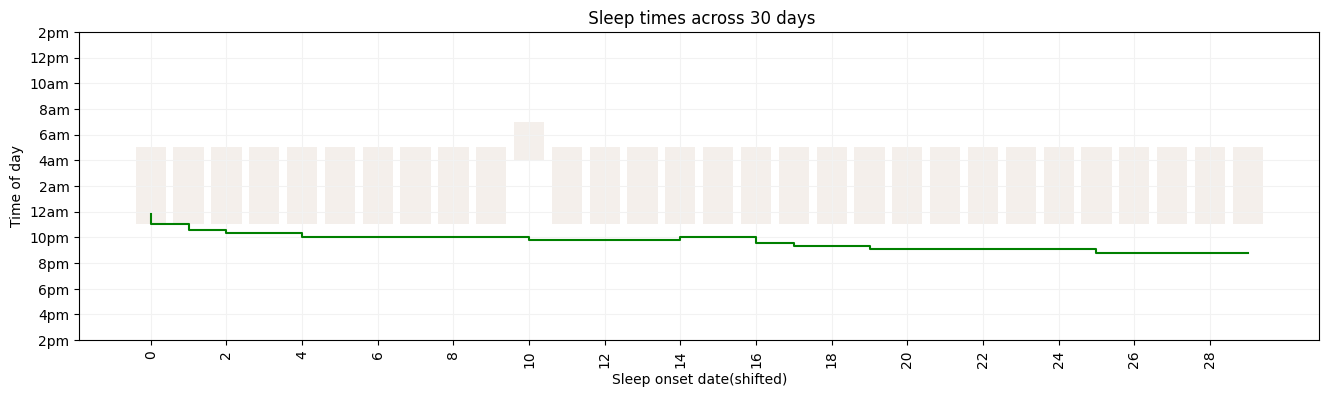

In [57]:
where_type = "pre"
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color="#F4EFEB")


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
    

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")

EstimatedSleepOnset_SleepWake = EstimatedSleepOnset #saving this in a new array

axs.step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset, 
         color='GREEN', where=where_type, label = "Predicted sleep onset - Sleep Wake")
axs.grid(color='0.95')


plt.show()

In [10]:
peak_values = [300,1000,3000,5000,7500,10000]
num_days = 15
hourly_light = [300,300,300,300,300,300,300,300,0,0,0,0,0,0,0,300,300,300,300,300,300,300,300,300]

x1_x2_dlmo = []
for peak in peak_values:
    light_values = []
    for hour in hourly_light:
        if hour == 0:
            j=0
            while j <4:
                light_values.append(0)
                j+=1
        else:
            j=0
            while j <4:
                light_values.append(peak)
                j+=1
    light_values = light_values*num_days
    hr24marker = int(len(light_values)/(24*4))
    ts = np.arange(0, 24*hr24marker, 0.25)
    # print("len of ts: ",len(ts))

    x1_list = np.arange(-1,2,0.01)
    x2_list = np.arange(-2,-1,0.01)
    for x1 in x1_list:
        for x2 in x2_list:
            initial_conditions_kj,sol = initial_conditions_loop(x1, x2,ts, light_est=light_values, num_loops=1)
            dlmo_kj = dlmos(sol)
            dlmo_kj2 = []
            for i in range(len(dlmo_kj)):
                if dlmo_kj[i] <0:
                    dlmo_kj2.append(24+dlmo_kj[i])
                elif i > 1:
                    dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
                else:
                    dlmo_kj2.append(dlmo_kj[i])  
                    for i in range(len(dlmo_kj2)):
                        if dlmo_kj2[i] < 0:
                            dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
            x1_x2_dlmo.append([peak, np.round(x1, 2),np.round(x2, 2),np.round(dlmo_kj2[0],2)])                
    x1_x2_dlmo_df = pd.DataFrame(x1_x2_dlmo,columns=['peak','x1','x2','dlmo'])


In [11]:
x1_x2_dlmo_df.to_csv("/data/work/shared/s210142/datasets/x1_x2_dlmo_actual2.csv")

In [14]:
x1_x2_dlmo_df = pd.read_csv("/data/work/shared/s210142/datasets/x1_x2_dlmo_actual2.csv")
x1_x2_dlmo_df.head()
x1_x2_dlmo_df['peak'].unique()

array([  300,  1000,  3000,  5000,  7500, 10000])

<AxesSubplot: xlabel='x2', ylabel='x1'>

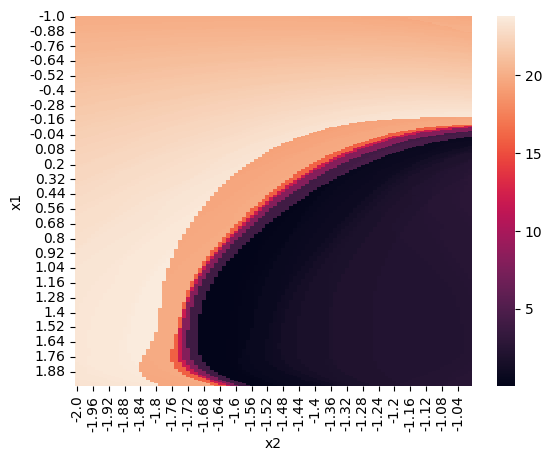

In [15]:
x1_x2_dlmo_pivot = pd.pivot_table(data=x1_x2_dlmo_df,values='dlmo',index='x1',columns='x2')
sns.heatmap(x1_x2_dlmo_pivot)

In [210]:
x1_x2_dlmo_df['dlmo'].unique()

array([19.550000, 19.300000, 19.800000, 20.050000, 20.300000, 20.550000,
       20.800000, 21.050000, 21.300000, 21.550000, 21.800000, 22.050000,
       22.300000, 22.550000, 22.800000, 23.050000, 23.300000, 23.550000,
       23.800000, 0.050000, 0.300000, 0.550000, 0.800000, 1.050000,
       2.050000, 2.300000])

In [176]:
dlmo_kj2 = []
for i in range(len(dlmo_kj)):
    if dlmo_kj[i] <0:
        dlmo_kj2.append(24+dlmo_kj[i])
    elif i > 1:
        dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
    else:
        dlmo_kj2.append(dlmo_kj[i])  

'''based on the numbers of 24 hours we need to go back, 
a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
'''
print(np.array(dlmo_kj2))
for i in range(len(dlmo_kj2)):
    if dlmo_kj2[i] < 0:
        dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
print(np.array(dlmo_kj2))
#here

[20.050000 23.300000 24.050000 25.050000 26.550000 27.300000 27.800000
 28.300000 28.550000 28.800000 29.050000 29.050000 29.300000 29.300000
 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000
 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000
 29.300000 29.300000]
[20.050000 23.300000 24.050000 25.050000 26.550000 27.300000 27.800000
 28.300000 28.550000 28.800000 29.050000 29.050000 29.300000 29.300000
 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000
 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000
 29.300000 29.300000]


In [177]:
def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes

import matplotlib.ticker as ticker

    
sleep_48hr = list(SleepingDates_48hr['start_time_num_round'])        
#calculating estimated sleep based on 2hr gap between dlmo and sleep onset
EstimatedSleepOnset = []

for dlmo_time  in dlmo_kj2:
    if dlmo_time < 12:
        EstimatedSleepOnset.append(np.round(dlmo_time+12.0+2.0,2))
    else:
        EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))

MinutesBetweenPredictedAndActualSleep_sleepwake = []
for actual_time, est_time in zip(sleep_48hr,EstimatedSleepOnset):
    if not pd.isna(actual_time):
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(np.round(cvm(est_time)-cvm(actual_time),2))
    else:
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(None)
        
for sleep_date,sleep_time,est_time,mins  in zip(np.array(SleepingDates_48hr['sleep_start_shift']), 
                                                          np.array(SleepingDates_48hr['start_time_num_round']),
                                                          EstimatedSleepOnset,
                                               MinutesBetweenPredictedAndActualSleep_sleepwake):
    print("sleep date:",sleep_date, "Actual sleep time:",sleep_time, "Estimated sleep time: ",est_time, "Minutes in between: ",mins)    


sleep date: 0 Actual sleep time: 8.0 Estimated sleep time:  22.05 Minutes in between:  843.0
sleep date: 1 Actual sleep time: 8.0 Estimated sleep time:  25.3 Minutes in between:  1038.0
sleep date: 2 Actual sleep time: 8.0 Estimated sleep time:  26.05 Minutes in between:  1083.0
sleep date: 3 Actual sleep time: 8.0 Estimated sleep time:  27.05 Minutes in between:  1143.0
sleep date: 4 Actual sleep time: 8.0 Estimated sleep time:  28.55 Minutes in between:  1233.0
sleep date: 5 Actual sleep time: 8.0 Estimated sleep time:  29.3 Minutes in between:  1278.0
sleep date: 6 Actual sleep time: 8.0 Estimated sleep time:  29.8 Minutes in between:  1308.0
sleep date: 7 Actual sleep time: 8.0 Estimated sleep time:  30.3 Minutes in between:  1338.0
sleep date: 8 Actual sleep time: 8.0 Estimated sleep time:  30.55 Minutes in between:  1353.0
sleep date: 9 Actual sleep time: 8.0 Estimated sleep time:  30.8 Minutes in between:  1368.0
sleep date: 10 Actual sleep time: 8.0 Estimated sleep time:  31.05

In [178]:
print(len(SleepingDates_48hr['sleep_start_shift']),len(SleepingDates_48hr['start_time_num_round']),
     len(EstimatedSleepOnset),len(dlmo_kj2))

30 30 30 30


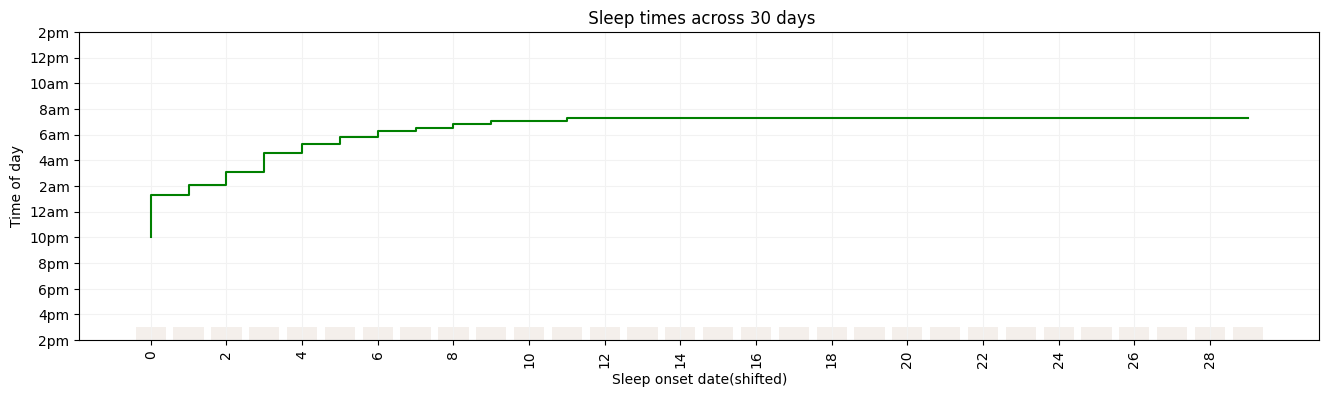

In [179]:
where_type = "pre"
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color="#F4EFEB")


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
    

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")

EstimatedSleepOnset_SleepWake = EstimatedSleepOnset #saving this in a new array

axs.step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset, 
         color='GREEN', where=where_type, label = "Predicted sleep onset - Sleep Wake")
axs.grid(color='0.95')


plt.show()

### Regular sleep start at 0800 and wake at 1500 for the first 15 days and 2300 - 0500 for the remaining

len of df:  15
len of df2:  15
len after concatenating:  30


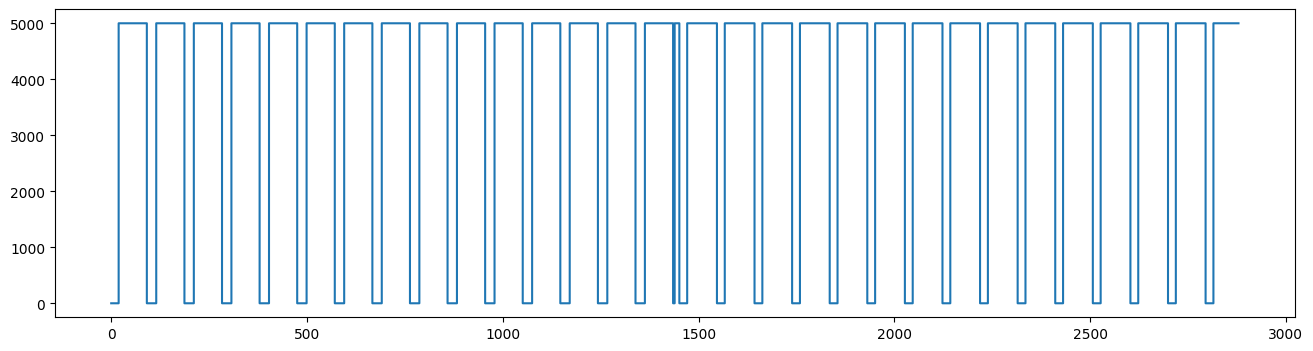

,start_time_num_round,end_time_num_round,sleep_duration_round
25,27.0,32.0,5.0
26,27.0,32.0,5.0
27,27.0,32.0,5.0
28,27.0,32.0,5.0
29,27.0,32.0,5.0


In [29]:
'''
First 15 days: Sleep onset:- 2300, sleep end time:- 0500
First 15 days: Sleep onset:- 0300, sleep end time:- 0800
'''
import pandas as pd
import matplotlib.pyplot as plt
k= 5000
# First 15 days
num_days = 15
# hourly_light = [k,k,k,k,k,k,k,k,0,0,0,0,0,0,0,k,k,k,k,k,k,k,k,k]
hourly_light = [0,0,0,0,0,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,0]

_df= []
for i in range(num_days):
    _df.append([23.0,29.0,6.0])
_df = pd.DataFrame(_df,columns=['start_time_num_round','end_time_num_round','sleep_duration_round'])   
print("len of df: ", len(_df))

light_values = []
for hour in hourly_light:
    if hour == 0:
        j=0
        while j <4:
            light_values.append(0)
            j+=1
    else:
        j=0
        while j <4:
            light_values.append(k)
            j+=1
light_values = light_values*num_days

# Next 15 days
num_days = 15
# hourly_light = [0,0,0,0,0,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k]
hourly_light = [k,k,k,0,0,0,0,0,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k]

_df2= []
for i in range(num_days):
    _df2.append([27.0,32.0,5.0])
_df2 = pd.DataFrame(_df2,columns=['start_time_num_round','end_time_num_round','sleep_duration_round'])   
print("len of df2: ", len(_df2))


_df = pd.concat([_df,_df2]).reset_index()
_df.drop(columns=['index'],inplace=True)
print("len after concatenating: ",len(_df))

light_values2 = []
for hour in hourly_light:
    if hour == 0:
        j=0
        while j <4:
            light_values2.append(0)
            j+=1
    else:
        j=0
        while j <4:
            light_values2.append(k)
            j+=1
light_values2 = light_values2*num_days
light_values = light_values+light_values2


plt.figure(figsize=(16,4))
plt.step(np.arange(0,len(light_values),1),light_values)
plt.show()

_df.tail()

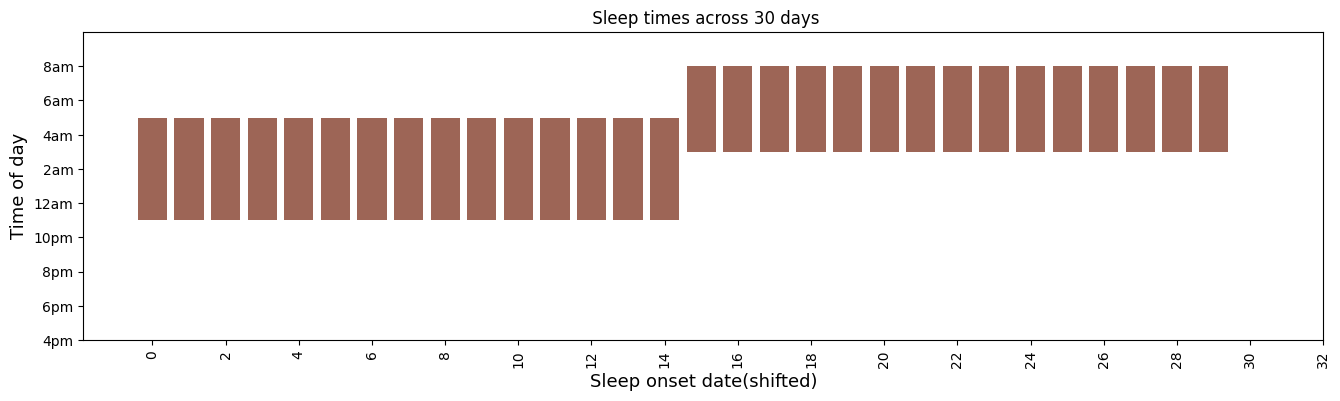

In [30]:
sleeping = np.array(_df['start_time_num_round'])
sleeping_48hour = []
for sleeping_time in sleeping:
    sleeping_48hour.append(sleeping_time)

                
SleepingDates = np.arange(0,34,1)
sleep_duration = _df['sleep_duration_round']

SleepingDates_48hr = pd.DataFrame(zip(SleepingDates, sleeping_48hour,sleep_duration),
                                  columns=['sleep_start_shift','start_time_num_round',
                                           'sleep_duration_round']) #converting to df
    
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(16,34)
axs.set_yticks(np.arange(16,34,2))
axs.set_yticklabels(['4pm','6pm','8pm','10pm','12am','2am','4am', '6am', '8am'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color='#9D6556')

set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)",fontsize=13)
plt.ylabel("Time of day",fontsize=13)

plt.show()

In [31]:
# light_values = np.array(date_sleep_combo["asleep_0_awake_300"])
print(type(light_values),len(light_values))
time_array = np.arange(0,len(light_values))
light_values

import matplotlib.pyplot as plt

hr24marker = int(len(light_values)/(24*4))
print("Whole days: ",hr24marker)


ts = np.arange(0, 24*hr24marker, 0.25)
print("len of ts: ",len(ts))

initial_conditions_kj,sol = initial_conditions_loop(ts, light_est=light_values, num_loops=1)
print("initial conditions:", initial_conditions_kj)


dlmo_kj = dlmos(sol)
print("length of time array: ",len(ts),"length of dlmo: ",len(dlmo_kj))
print(len(dlmo_kj))
# for data in np.array(dlmo_kj):
#     print("{:9.2f}".format(data))

type(dlmo_kj)
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})
print(dlmo_kj)

dlmo_kj2 = []
for i in range(len(dlmo_kj)):
    if dlmo_kj[i] <0:
        dlmo_kj2.append(24+dlmo_kj[i])
    elif i > 1:
        dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
    else:
        dlmo_kj2.append(dlmo_kj[i])  

'''based on the numbers of 24 hours we need to go back, 
a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
'''
print(np.array(dlmo_kj2))
for i in range(len(dlmo_kj2)):
    if dlmo_kj2[i] < 0:
        dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
print(np.array(dlmo_kj2))

def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes

import matplotlib.ticker as ticker

    
sleep_48hr = list(SleepingDates_48hr['start_time_num_round'])        
#calculating estimated sleep based on 2hr gap between dlmo and sleep onset
EstimatedSleepOnset = []

for dlmo_time  in dlmo_kj2:
    if dlmo_time < 12:
        EstimatedSleepOnset.append(np.round(dlmo_time+24.0+2.0,2))
    else:
        EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))

MinutesBetweenPredictedAndActualSleep_sleepwake = []
for actual_time, est_time in zip(sleep_48hr,EstimatedSleepOnset):
    if not pd.isna(actual_time):
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(np.round(cvm(est_time)-cvm(actual_time),2))
    else:
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(None)
        
# for sleep_date,sleep_time,est_time,mins  in zip(np.array(SleepingDates_48hr['sleep_start_shift']), 
#                                                           np.array(SleepingDates_48hr['start_time_num_round']),
#                                                           EstimatedSleepOnset,
#                                                MinutesBetweenPredictedAndActualSleep_sleepwake):
#     print("sleep date:",sleep_date, "Actual sleep time:",sleep_time, "Estimated sleep time: ",est_time, "Minutes in between: ",mins)    

# print(len(SleepingDates_48hr['sleep_start_shift']),len(SleepingDates_48hr['start_time_num_round']),
#      len(EstimatedSleepOnset),len(dlmo_kj2))


<class 'list'> 2880
Whole days:  30
len of ts:  2880
initial conditions: [0.034439 -1.378482 0.893320]
length of time array:  2880 length of dlmo:  30
30
[-2.200000 20.300000 43.800000 67.550000 91.550000 115.550000 139.550000
 163.550000 187.550000 211.550000 235.550000 259.550000 283.550000
 307.550000 331.550000 355.550000 381.550000 406.050000 430.300000
 454.550000 478.800000 502.800000 526.800000 551.050000 575.050000
 599.050000 623.050000 647.050000 671.050000 695.050000]
[21.800000 20.300000 19.800000 19.550000 19.550000 19.550000 19.550000
 19.550000 19.550000 19.550000 19.550000 19.550000 19.550000 19.550000
 19.550000 19.550000 21.550000 22.050000 22.300000 22.550000 22.800000
 22.800000 22.800000 23.050000 23.050000 23.050000 23.050000 23.050000
 23.050000 23.050000]
[21.800000 20.300000 19.800000 19.550000 19.550000 19.550000 19.550000
 19.550000 19.550000 19.550000 19.550000 19.550000 19.550000 19.550000
 19.550000 19.550000 21.550000 22.050000 22.300000 22.550000 22.800

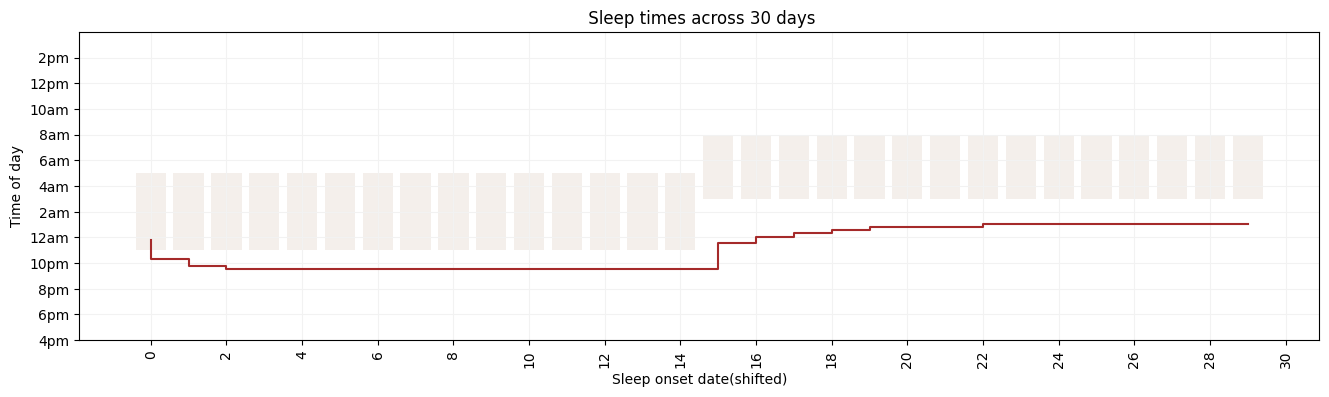

In [32]:
where_type = "pre"
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(16,40)
axs.set_yticks(np.arange(16,40,2))
axs.set_yticklabels(['4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color="#F4EFEB")


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
    

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")

EstimatedSleepOnset_SleepWake = EstimatedSleepOnset #saving this in a new array

axs.step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset, 
         color='BROWN', where=where_type, label = "Predicted sleep onset - Sleep Wake")
axs.grid(color='0.95')


plt.show()

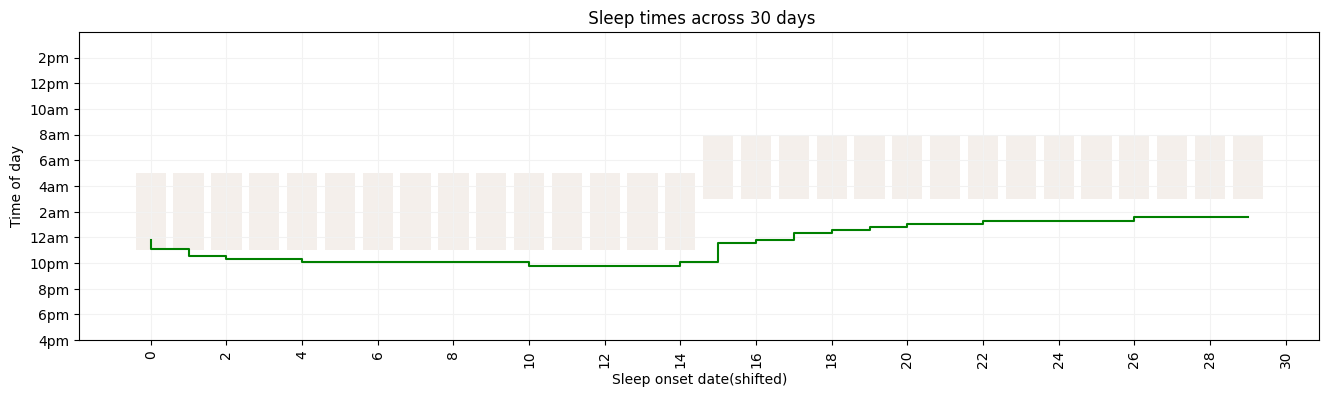

In [23]:
where_type = "pre"
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(16,40)
axs.set_yticks(np.arange(16,40,2))
axs.set_yticklabels(['4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color="#F4EFEB")


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
    

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")

EstimatedSleepOnset_SleepWake = EstimatedSleepOnset #saving this in a new array

axs.step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset, 
         color='GREEN', where=where_type, label = "Predicted sleep onset - Sleep Wake")
axs.grid(color='0.95')


plt.show()

### Regular sleep starting at 0800hrs and ending at 1500 everyday

len of df:  30


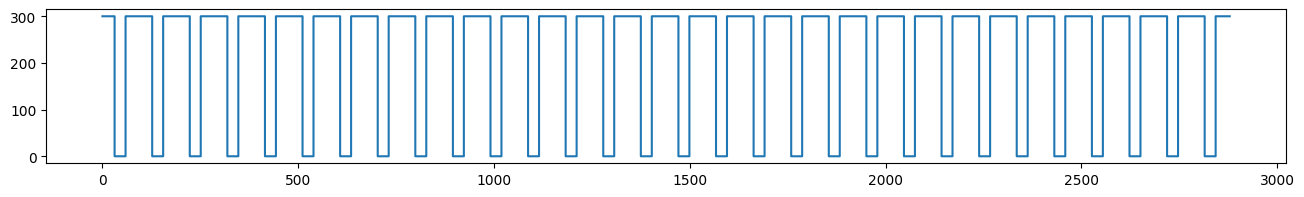

,start_time_num_round,end_time_num_round,sleep_duration_round
0,8.0,15.0,7.0
1,8.0,15.0,7.0
2,8.0,15.0,7.0
3,8.0,15.0,7.0
4,8.0,15.0,7.0


In [184]:
'''
User sleeping at 0800 and waking up at 1500 everyday
'''
num_days=30

hourly_light = [300,300,300,300,300,300,300,300,0,0,0,0,0,0,0,300,300,300,300,300,300,300,300,300]

_df= []
for i in range(num_days):
    _df.append([8.0,15.0,7.0])
_df = pd.DataFrame(_df,columns=['start_time_num_round','end_time_num_round','sleep_duration_round'])   
print("len of df: ", len(_df))

light_values = []
for hour in hourly_light:
    if hour == 0:
        j=0
        while j <4:
            light_values.append(0)
            j+=1
    else:
        j=0
        while j <4:
            light_values.append(300)
            j+=1
light_values = light_values*num_days
plt.figure(figsize=(16,2))
plt.step(np.arange(0,len(light_values),1),light_values)
plt.show()
_df.head()

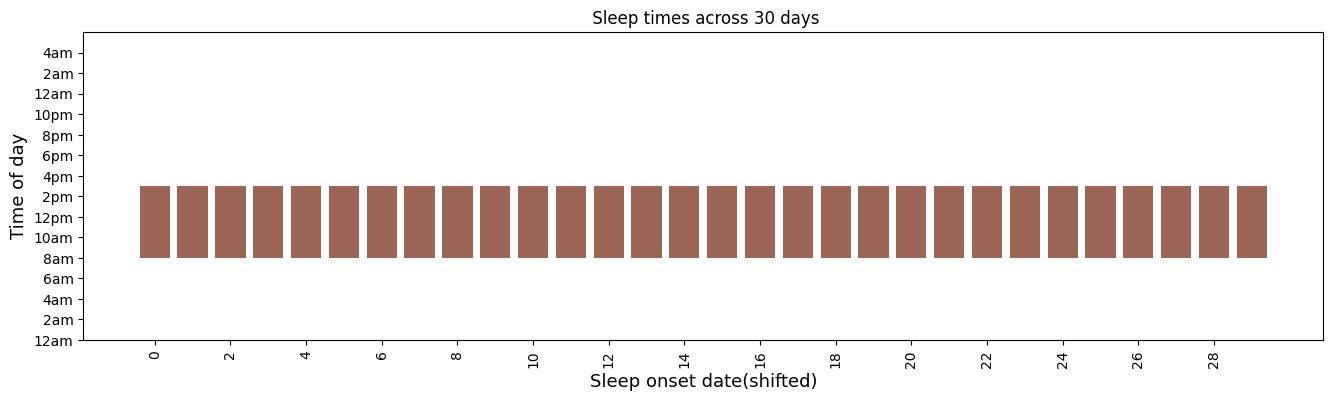

In [185]:
sleeping = np.array(_df['start_time_num_round'])
sleeping_48hour = []
for sleeping_time in sleeping:
#     if sleeping_time < 12.00:
#         sleeping_48hour.append(sleeping_time+24.00)
#     else:
#         sleeping_48hour.append(sleeping_time) 

    sleeping_48hour.append(sleeping_time)
    

                
SleepingDates = np.arange(0,num_days,1)
sleep_duration = _df['sleep_duration_round']

SleepingDates_48hr = pd.DataFrame(zip(SleepingDates, sleeping_48hour,sleep_duration),
                                  columns=['sleep_start_shift','start_time_num_round',
                                           'sleep_duration_round']) #converting to df


    
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(0,30)
axs.set_yticks(np.arange(0,30,2))
axs.set_yticklabels(['12am','2am','4am','6am','8am','10am','12pm','2pm','4pm','6pm','8pm','10pm','12am','2am','4am'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color='#9D6556')

set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)",fontsize=13)
plt.ylabel("Time of day",fontsize=13)

plt.show()

<class 'list'> 2880
Whole days:  30
len of ts:  2880
n:  2880
[-0.800000 -1.800000 0.000000]
initial conditions: [1.045330 0.080049 0.607560]
cbts values:  [-0.800000 -0.867421 -0.939847 ... 1.038589 1.044433 1.045330]
cbts:  2880


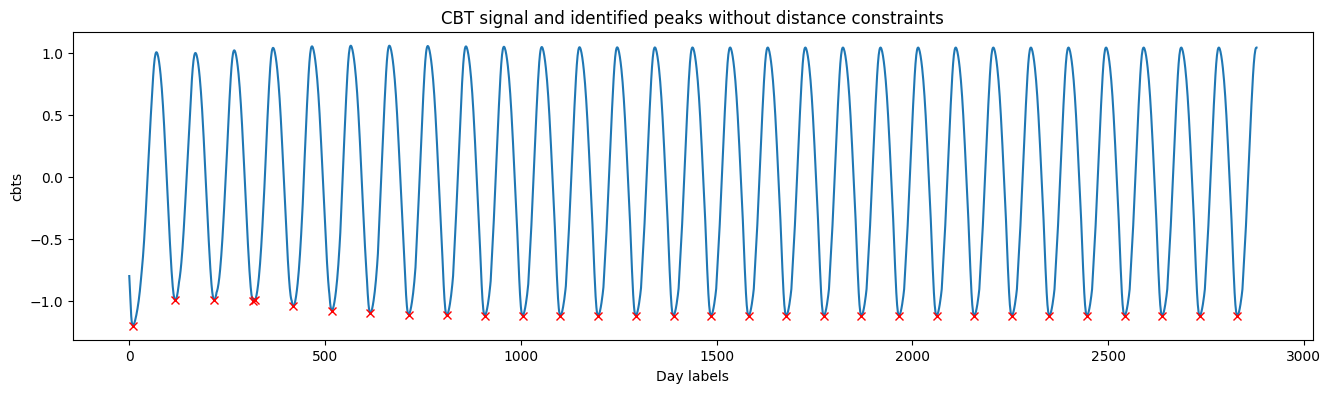

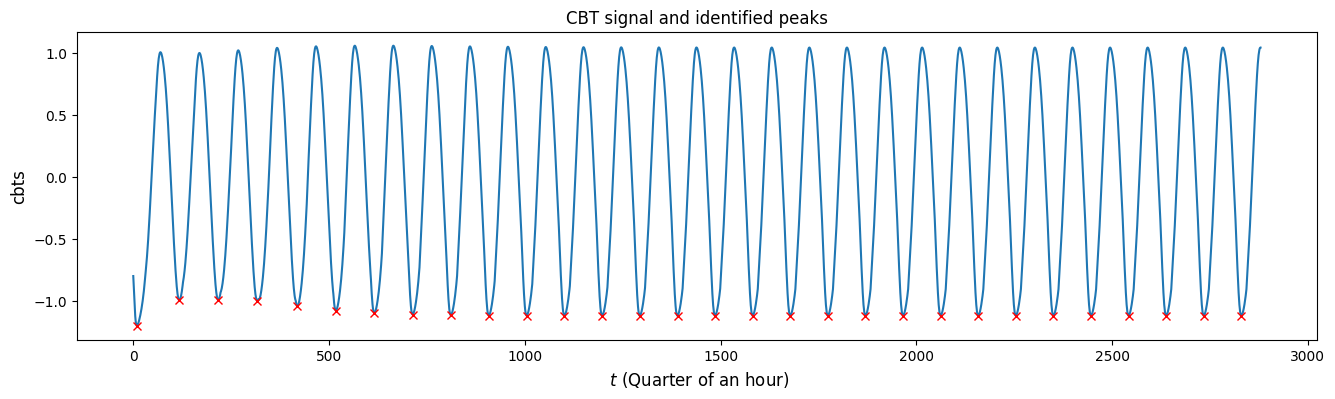

length cbt mins: (30,)
length of time array:  2880 length of dlmo:  30
30
[-3.950000 23.300000 48.050000 73.050000 98.550000 123.300000 147.800000
 172.300000 196.550000 220.800000 245.050000 269.050000 293.300000
 317.300000 341.300000 365.300000 389.300000 413.300000 437.300000
 461.300000 485.300000 509.300000 533.300000 557.300000 581.300000
 605.300000 629.300000 653.300000 677.300000 701.300000]
[20.050000 23.300000 24.050000 25.050000 26.550000 27.300000 27.800000
 28.300000 28.550000 28.800000 29.050000 29.050000 29.300000 29.300000
 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000
 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000
 29.300000 29.300000]
[20.050000 23.300000 24.050000 25.050000 26.550000 27.300000 27.800000
 28.300000 28.550000 28.800000 29.050000 29.050000 29.300000 29.300000
 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000
 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000 29.300000
 29.3

In [186]:
# light_values = np.array(date_sleep_combo["asleep_0_awake_300"])
print(type(light_values),len(light_values))
time_array = np.arange(0,len(light_values))
light_values

import matplotlib.pyplot as plt

hr24marker = int(len(light_values)/(24*4))
print("Whole days: ",hr24marker)


ts = np.arange(0, 24*hr24marker, 0.25)
print("len of ts: ",len(ts))

initial_conditions_kj,sol = initial_conditions_loop(ts, light_est=light_values, num_loops=1)
print("initial conditions:", initial_conditions_kj)


dlmo_kj = dlmos(sol)
print("length of time array: ",len(ts),"length of dlmo: ",len(dlmo_kj))
print(len(dlmo_kj))
# for data in np.array(dlmo_kj):
#     print("{:9.2f}".format(data))

type(dlmo_kj)
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})
print(dlmo_kj)

dlmo_kj2 = []
for i in range(len(dlmo_kj)):
    if dlmo_kj[i] <0:
        dlmo_kj2.append(24+dlmo_kj[i])
    elif i > 1:
        dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
    else:
        dlmo_kj2.append(dlmo_kj[i])  

'''based on the numbers of 24 hours we need to go back, 
a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
'''
print(np.array(dlmo_kj2))
for i in range(len(dlmo_kj2)):
    if dlmo_kj2[i] < 0:
        dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
print(np.array(dlmo_kj2))

def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes

import matplotlib.ticker as ticker

    
sleep_48hr = list(SleepingDates_48hr['start_time_num_round'])        
#calculating estimated sleep based on 2hr gap between dlmo and sleep onset
EstimatedSleepOnset = []

for dlmo_time  in dlmo_kj2:
    if dlmo_time < 12:
        EstimatedSleepOnset.append(np.round(dlmo_time+12.0+2.0,2))
    else:
        EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))

MinutesBetweenPredictedAndActualSleep_sleepwake = []
for actual_time, est_time in zip(sleep_48hr,EstimatedSleepOnset):
    if not pd.isna(actual_time):
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(np.round(cvm(est_time)-cvm(actual_time),2))
    else:
        MinutesBetweenPredictedAndActualSleep_sleepwake.append(None)
        
for sleep_date,sleep_time,est_time,mins  in zip(np.array(SleepingDates_48hr['sleep_start_shift']), 
                                                          np.array(SleepingDates_48hr['start_time_num_round']),
                                                          EstimatedSleepOnset,
                                               MinutesBetweenPredictedAndActualSleep_sleepwake):
    print("sleep date:",sleep_date, "Actual sleep time:",sleep_time, "Estimated sleep time: ",est_time, "Minutes in between: ",mins)    

print(len(SleepingDates_48hr['sleep_start_shift']),len(SleepingDates_48hr['start_time_num_round']),
     len(EstimatedSleepOnset),len(dlmo_kj2))


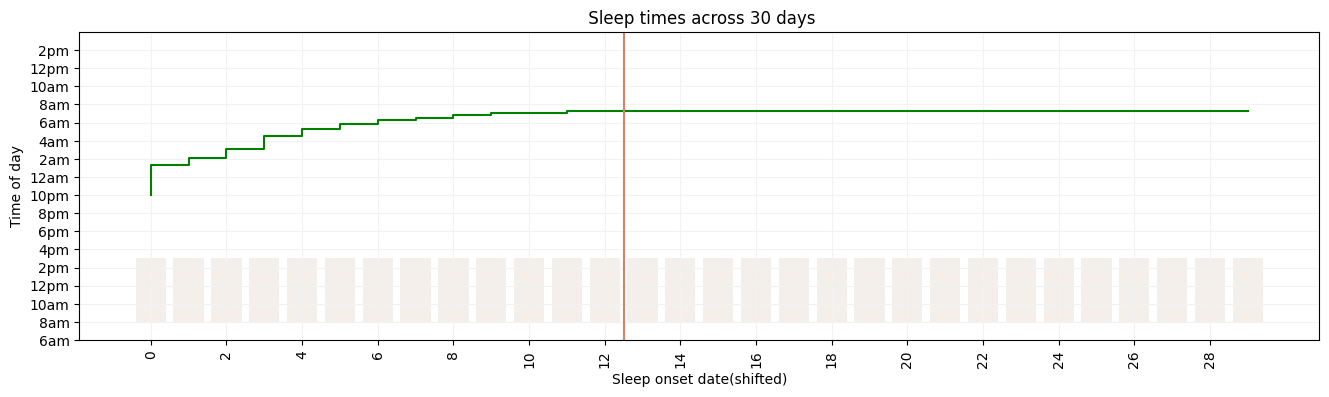

In [187]:
where_type = "pre"
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(6,40)
axs.set_yticks(np.arange(6,40,2))
axs.set_yticklabels(['6am','8am','10am','12pm','2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color="#F4EFEB")


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
    

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")

EstimatedSleepOnset_SleepWake = EstimatedSleepOnset #saving this in a new array

axs.step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset, 
         color='GREEN', where=where_type, label = "Predicted sleep onset - Sleep Wake")
axs.grid(color='0.95')
axs.axvline(x=12.5, color='#db8065')

plt.show()

## User sleeping at 0100 and waking up at 0700 everyday for 60 days

len of df:  90


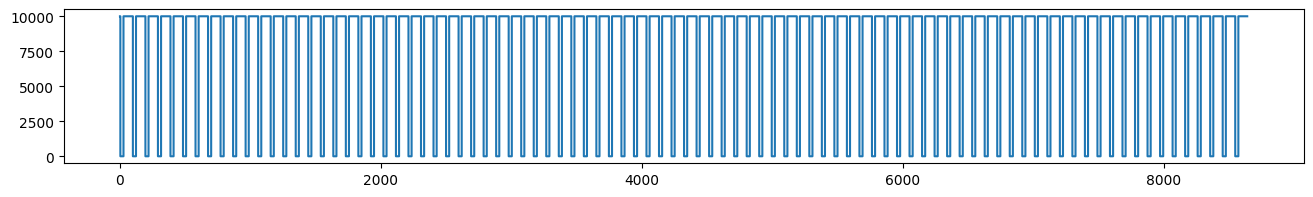

,start_time_num_round,end_time_num_round,sleep_duration_round
0,1.0,7.0,6.0
1,1.0,7.0,6.0
2,1.0,7.0,6.0
3,1.0,7.0,6.0
4,1.0,7.0,6.0


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
'''
User sleeping at 0800 and waking up at 1500 everyday
'''
num_days=90
k = 10000
# hourly_light = [300,0,0,0,0,0,0,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300]
hourly_light = [k,0,0,0,0,0,0,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k,k]

_df= []
for i in range(num_days):
    _df.append([1.0,7.0,6.0])
_df = pd.DataFrame(_df,columns=['start_time_num_round','end_time_num_round','sleep_duration_round'])   
print("len of df: ", len(_df))

light_values = []
for hour in hourly_light:
    if hour == 0:
        j=0
        while j <4:
            light_values.append(0)
            j+=1
    else:
        j=0
        while j <4:
            light_values.append(k)
            j+=1
light_values = light_values*num_days
plt.figure(figsize=(16,2))
plt.step(np.arange(0,len(light_values),1),light_values)
plt.show()
_df.head()

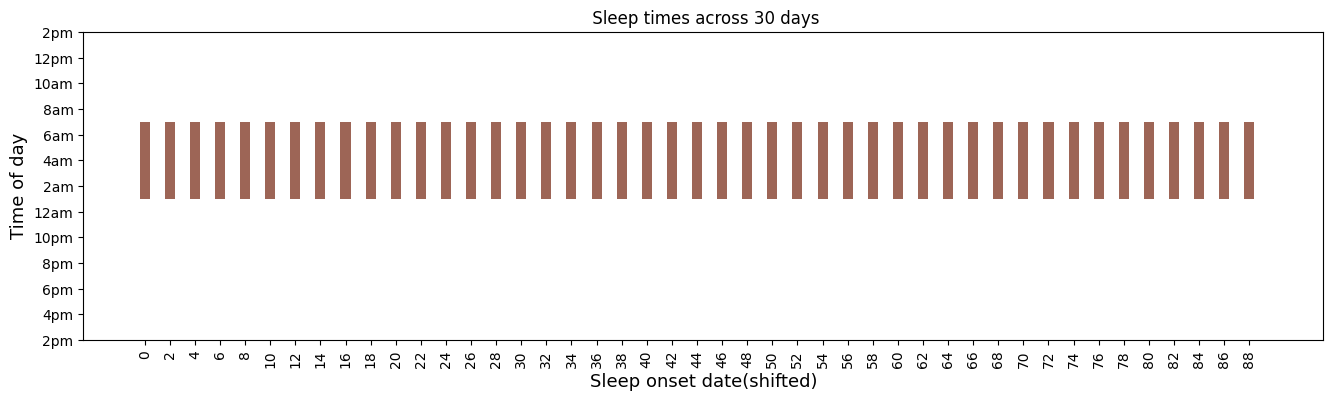

In [31]:
sleeping = np.array(_df['start_time_num_round'])
sleeping_48hour = []
for sleeping_time in sleeping:
    if sleeping_time < 12.00:
        sleeping_48hour.append(sleeping_time+24.00)
    else:
        sleeping_48hour.append(sleeping_time) 

    sleeping_48hour.append(sleeping_time)
    

                
SleepingDates = np.arange(0,num_days,1)
sleep_duration = _df['sleep_duration_round']

SleepingDates_48hr = pd.DataFrame(zip(SleepingDates, sleeping_48hour,sleep_duration),
                                  columns=['sleep_start_shift','start_time_num_round',
                                           'sleep_duration_round']) #converting to df


    
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color='#9D6556')

set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
        
plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)",fontsize=13)
plt.ylabel("Time of day",fontsize=13)

plt.show()

In [32]:
# light_values = np.array(date_sleep_combo["asleep_0_awake_300"])
print(type(light_values),len(light_values))
time_array = np.arange(0,len(light_values))
light_values

import matplotlib.pyplot as plt

hr24marker = int(len(light_values)/(24*4))
print("Whole days: ",hr24marker)


ts = np.arange(0, 24*hr24marker, 0.25)
print("len of ts: ",len(ts))

initial_conditions_kj,sol = initial_conditions_loop(ts, light_est=light_values, num_loops=1)
print("initial conditions:", initial_conditions_kj)


dlmo_kj = dlmos(sol)
print("length of time array: ",len(ts),"length of dlmo: ",len(dlmo_kj))
# print(len(dlmo_kj))

type(dlmo_kj)
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})
# print(dlmo_kj)

dlmo_kj2 = []
for i in range(len(dlmo_kj)):
    if dlmo_kj[i] <0:
        dlmo_kj2.append(24+dlmo_kj[i])
    elif i > 1:
        dlmo_kj2.append(dlmo_kj[i]-(24*(i-1)))
    else:
        dlmo_kj2.append(dlmo_kj[i])  

'''based on the numbers of 24 hours we need to go back, 
a ceiling function(in effect) is applied to make sure we always round up.Floor is used because the numbers
are negative therefore a ceiling effect is produced by rounding downwards for negative numbers
'''
# print(np.array(dlmo_kj2))
for i in range(len(dlmo_kj2)):
    if dlmo_kj2[i] < 0:
        dlmo_kj2[i] = (24*abs(math.floor(dlmo_kj2[i]/24)))+dlmo_kj2[i]
# print(np.array(dlmo_kj2))

def cvm(ip_time):
    TimeInMinutes = int(ip_time)*60+((ip_time%1)*60)
    return TimeInMinutes

import matplotlib.ticker as ticker

    
sleep_48hr = list(SleepingDates_48hr['start_time_num_round'])        
#calculating estimated sleep based on 2hr gap between dlmo and sleep onset
EstimatedSleepOnset = []

for dlmo_time  in dlmo_kj2:
    if dlmo_time < 12:
        EstimatedSleepOnset.append(np.round(dlmo_time+12.0+2.0,2))
    else:
        EstimatedSleepOnset.append(np.round(dlmo_time+2.0,2))

<class 'list'> 8640
Whole days:  90
len of ts:  8640
initial conditions: [-0.512564 -1.347937 0.926960]
length of time array:  8640 length of dlmo:  90


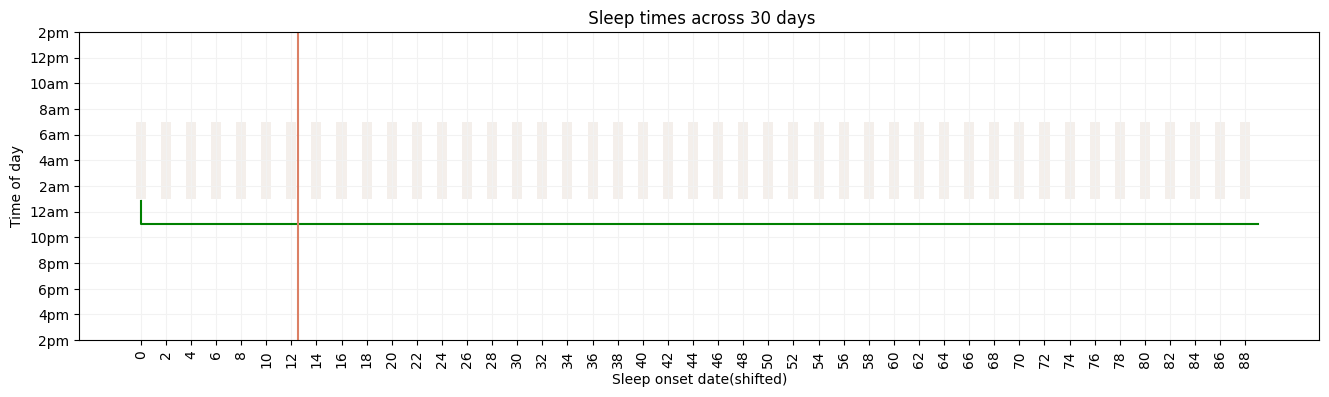

In [33]:
where_type = "pre"
fig,axs = plt.subplots(figsize=(16,4))
axs.set_ylim(14,38)
axs.set_yticks(np.arange(14,40,2))
axs.set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['start_time_num_round'],color='white')
axs.bar(SleepingDates_48hr['sleep_start_shift'],SleepingDates_48hr['sleep_duration_round'],
        bottom = SleepingDates_48hr['start_time_num_round'],color="#F4EFEB")


set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s)
    

plt.xticks(date_list2)
plt.tick_params(axis='x',rotation=90)      
plt.xlabel("Sleep Onset date (shifted)")

plt.tick_params('x',rotation=90)
plt.title(" Sleep times across 30 days")
plt.xlabel("Sleep onset date(shifted)")
plt.ylabel("Time of day")

EstimatedSleepOnset_SleepWake = EstimatedSleepOnset #saving this in a new array

axs.step(SleepingDates_48hr['sleep_start_shift'],EstimatedSleepOnset, 
         color='GREEN', where=where_type, label = "Predicted sleep onset - Sleep Wake")
axs.grid(color='0.95')
axs.axvline(x=12.5, color='#db8065')

plt.show()